Calibrate the ITFR by fitting both galaxies in the Coma cluster and those used for 0-pt calibration simultaneously.

**Note**: This requires using a subclassed version of `hyperfit`.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle

import os

import requests

import corner

import pickle

from help_functions import adjust_lightness

import sys
sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
#sys.path.insert(1, '/Users/kellydouglass/Documents/Research/DESI/Targets/code/TF/')
from line_fits import param_invert, hyperfit_line_multi

In [2]:
h = 1
H0 = 100*h

c = 3e5

q0 = 0.2

# V0 is set to be the median value of all data used in the calibration

# Data

## fuji

In [3]:
# tfuji = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/SV/SGA-2020_fuji_Vrot.fits')
tfuji = Table.read('/global/cfs/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits')
#tfuji = Table.read('/Users/kellydouglass/Documents/Research/data/DESI/SV/desi_pv_tf_fuji_healpix.fits')
tfuji[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64
1079550234591232,194.390863195343,27.5157211790145,10378,sv3,1.1235686466514,7.31685779475115e-05,4,3.28414569795132,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124544,194.390863195343,27.5157211790145,10378,sv3,0.686773088332363,6.9756676262104e-05,4,0.786607094109058,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124546,194.364461113654,27.5037185881314,10378,sv3,0.0242933923052181,4.95233472646785e-05,0,95.428411073226,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.36446111365385,27.50371858813136
1092744369930240,194.338458724402,27.4918902690326,10378,sv3,0.0264170223697961,0.00010139452689994,0,9.53278421035066,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.33845872440244,27.491890269032595
1092744374124545,194.377858465028,27.5098100780282,10378,sv3,0.211332646769145,6.68535116703737e-05,4,3.73989077657461,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3778584650283,27.509810078028195


## SGA

Read in our version of the SGA that includes distances from the Extragalactic Distance Database and Pantheon+SH0ES.  (This file was made with the `data_match.ipynb` notebook and the `data_match_PantheonSH0ES.ipynb` notebook.)

In [4]:
# SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')
#SGA = Table.read('/Users/kellydouglass/Documents/Research/data/SGA/SGA-2020.fits', 'ELLIPSE')
SGA = Table.read('../SGA_distances.fits')

SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,DM_Stellar,e_DM_lo_Stellar,e_DM_hi_Stellar,Stellar_Catalog,DM1_SN,e_DM1_SN,DM2_SN,e_DM2_SN,DM3_SN,e_DM3_SN,DM4_SN,e_DM4_SN,DM5_SN,e_DM5_SN,DM6_SN,e_DM6_SN,DM7_SN,e_DM7_SN,SN_Catalog,DM_PantheonSH0ES,e_DM_PantheonSH0ES,z_PantheonSH0ES,e_z_PantheonSH0ES,RA_PantheonSH0ES,DEC_PantheonSH0ES,CID_PantheonSH0ES
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,bytes14,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,bytes25,float64,float64,float64,float64,float64,float64,bytes15
5002480,SGA-2020 5002480,DR8-2837p402-5033,-1,283.619631436471,40.3162008554537,DEV,178.80934,0.54342,0.3166,-1.0,24.29036,16.9862,False,DR8,530781,DR8-2837p402-5033,1,True,283.619631436471,40.3162008554537,0.54342,2837p402,283.6196056669463,40.316337272867564,0.53864765,SB26,179.53694,0.3690244,283.6194583471782,40.31653379127378,11.641381,11.157478,8.614751,9.8993,1.6142721,3.685578,5.5844307,7.701021,9.878292,11.927793,13.400182,14.697571,16.15943,21.37251,20.373438,19.779512,19.920574,19.005274,18.41066,19.314016,18.435898,17.843414,18.922651,18.076838,17.494484,18.664383,17.833265,17.25879,18.496494,17.682926,17.106598,18.404135,17.605488,17.02742,18.332602,17.555883,16.971588,18.299273,17.52499,16.931496,0.04933311,0.065890566,0.09742977,0.10495926,0.1614855,0.27832195,0.15179653,0.13904023,0.20484819,0.041657884,0.06669066,0.06785251,0.038538612,0.049561314,0.05101378,0.03635901,0.041818976,0.042013034,0.03367074,0.03763669,0.03705858,0.03122176,0.03420294,0.0336

In [5]:
SGA_dict = {}

for i in range(len(SGA)):
    
    SGA_dict[SGA['SGA_ID'][i]] = i

## Separate the fuji data into center and off-center observations

In [6]:
tfuji['SKY_FIBER_DIST'] = 0.
tfuji['SKY_FIBER_DIST_R26'] = 0.

# For each SGA galaxy that has at least one observation, calculate the distance 
# for all of that galaxy's targets
for sga_id in np.unique(tfuji['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = tfuji['SGA_ID'] == sga_id
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center of the SGA 
    # galaxy
    #---------------------------------------------------------------------------
    SGA_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                          dec=SGA['DEC'][sga_idx], 
                          unit=u.degree)
    target_coords = SkyCoord(ra=tfuji['RA'][obs_idx], 
                             dec=tfuji['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(SGA_coords)
    
    tfuji['SKY_FIBER_DIST'][obs_idx] = sep2d
    tfuji['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------

In [7]:
centers_boolean = tfuji['SKY_FIBER_DIST_R26'] < 0.1

fuji_centers = tfuji[centers_boolean]
fuji_axis = tfuji[~centers_boolean]

### Clean the fuji center observations

Only keep those with
 * `DELTACHI2` > 25
 * `ZWARN` == 0

In [8]:
good_centers = fuji_centers[(fuji_centers['DELTACHI2'] > 25) & (fuji_centers['ZWARN'] == 0)]

### If an SGA galaxy has at least one observation at its center, set the redshift of that galaxy

In [9]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan

weights = 1./(good_centers['ZERR']**2)

for sga_id in np.unique(good_centers['SGA_ID']):
    
    # Find all the center observations of this galaxy
    obs_idx = good_centers['SGA_ID'] == sga_id
    
    # Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be the weighted average redshift of all 
    # good center observations
    SGA['Z_DESI'][SGA_idx] = np.average(good_centers['Z'][obs_idx], 
                                        weights=weights[obs_idx])
    SGA['ZERR_DESI'][SGA_idx] = np.sqrt(1./np.sum(weights[obs_idx]))

# Coma cluster membership

Following Cosmicflows4 (Kourkchi et al. 2020), cluster membership is defined as
- $R_p < 1.5R_{2t}$ and $v < V_c \pm 3\sigma_p$
- $1.5R_{2t} \leq R_p < 3R_{2t}$ and $v < V_c \pm 2\sigma_p$

where $R_p$ is the projected distance from the cluster center, $R_{2t}$ is the cluster projected second turnaround radius, $\sigma_p$ is the projected velocity dispersion of the cluster, and $V_c$ is the average heliocentric radial velocity of the cluster.

In [10]:
# Data table #3 from Tully (2015)
hdu = fits.open('../Tully15-Table3.fits')
table3 = Table(hdu[1].data)
hdu.close()

table3[:5]

f_Nest,Nest,Nmb,PGC1,SGLON,SGLAT,logLK,<Vcmba>,DM,sigV,R2t,sigP,Mlum,CF
int16,int32,int16,int32,float64,float64,float64,int32,float64,int16,float64,int16,float64,float64
1,100001,136,44715,89.6226,8.1461,13.15,7331,34.33,886,2.129,1045,1710000000000000.0,1.65
1,100002,197,41220,103.0008,-2.3248,12.69,1491,30.87,670,1.44,707,529000000000000.0,1.0
1,100003,113,43296,156.2336,-11.5868,12.75,3873,32.94,822,1.52,746,623000000000000.0,1.12
1,100004,81,58265,71.5103,49.7851,13.16,9424,34.87,740,2.153,1057,1770000000000000.0,2.26
1,100005,61,36487,92.0255,-10.495,12.78,6987,34.22,707,1.56,766,673000000000000.0,1.58


In [11]:
Coma_nest = 100001

Coma_row_t3 = table3['Nest'] == Coma_nest

R2t_Coma = table3['R2t'][Coma_row_t3][0]
sigma_Coma = table3['sigP'][Coma_row_t3][0]
mu_Coma = table3['DM'][Coma_row_t3][0]

Coma_coords = SkyCoord(table3['SGLON'][Coma_row_t3]*u.degree, 
                       table3['SGLAT'][Coma_row_t3]*u.degree, 
                       frame='supergalactic')

In [12]:
d_Coma = 10*10**(0.2*mu_Coma) # pc
V_Coma = 100*(d_Coma*1e-6) # km/s

V_Coma

7345.138681571143

## Calculate the projected distance between the Coma cluster and each SGA galaxy

In [13]:
# First, we need to convert R2t from Mpc to an angle, using the group's velocity
# Note that we are NOT assuming that the size of the cluster is a small angle!!
R2t_Coma_angle_1p5 = np.arctan(1.5*R2t_Coma/(d_Coma*1e-6))*u.radian
R2t_Coma_angle_3 = np.arctan(3*R2t_Coma/(d_Coma*1e-6))*u.radian

In [14]:
SGA_coords = SkyCoord(SGA['RA'], SGA['DEC'], unit='deg')

sep = Coma_coords.separation(SGA_coords)

In [15]:
SGA_in_Coma1 = (sep < R2t_Coma_angle_1p5) & (SGA['Z_DESI']*c > V_Coma - 3*sigma_Coma) & (SGA['Z_DESI']*c < V_Coma + 3*sigma_Coma)

SGA_in_Coma2 = (sep >= R2t_Coma_angle_1p5) & (sep < R2t_Coma_angle_3) & (SGA['Z_DESI']*c > V_Coma - 2*sigma_Coma) & (SGA['Z_DESI']*c < V_Coma + 2*sigma_Coma)
#SGA_in_Coma2 = (sep >= 1.5*R2t_Coma_angle) & (SGA['Z_DESI']*c > V_Coma - 2*sigma_Coma) & (SGA['Z_DESI']*c < V_Coma + 2*sigma_Coma)

SGA_in_Coma = SGA_in_Coma1 | SGA_in_Coma2

################################################################################
# Keep all observations of each galaxy that are within the Coma cluster
#-------------------------------------------------------------------------------
SGA_ID_in_Coma = SGA['SGA_ID'][SGA_in_Coma]

centers_inComa = good_centers[np.in1d(good_centers['SGA_ID'], SGA_ID_in_Coma)]

axis_inComa = fuji_axis[np.in1d(fuji_axis['SGA_ID'], SGA_ID_in_Coma)]
################################################################################

print('fuji galaxies in Coma with good center observations:', len(np.unique(centers_inComa['SGA_ID'])))
print('fuji off-center observations in Coma:', len(axis_inComa))

fuji galaxies in Coma with good center observations: 275
fuji off-center observations in Coma: 909


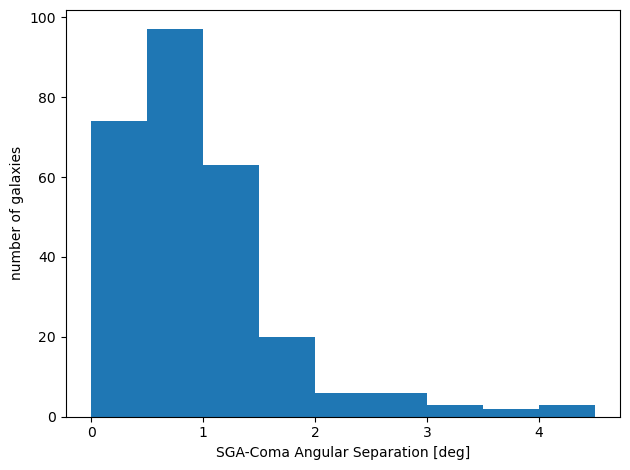

In [16]:
plt.figure(tight_layout=True)

plt.hist(sep[SGA_in_Coma].to_value('degree'), bins=np.arange(0, 5, 0.5))

plt.xlabel('SGA-Coma Angular Separation [deg]')
plt.ylabel('number of galaxies');

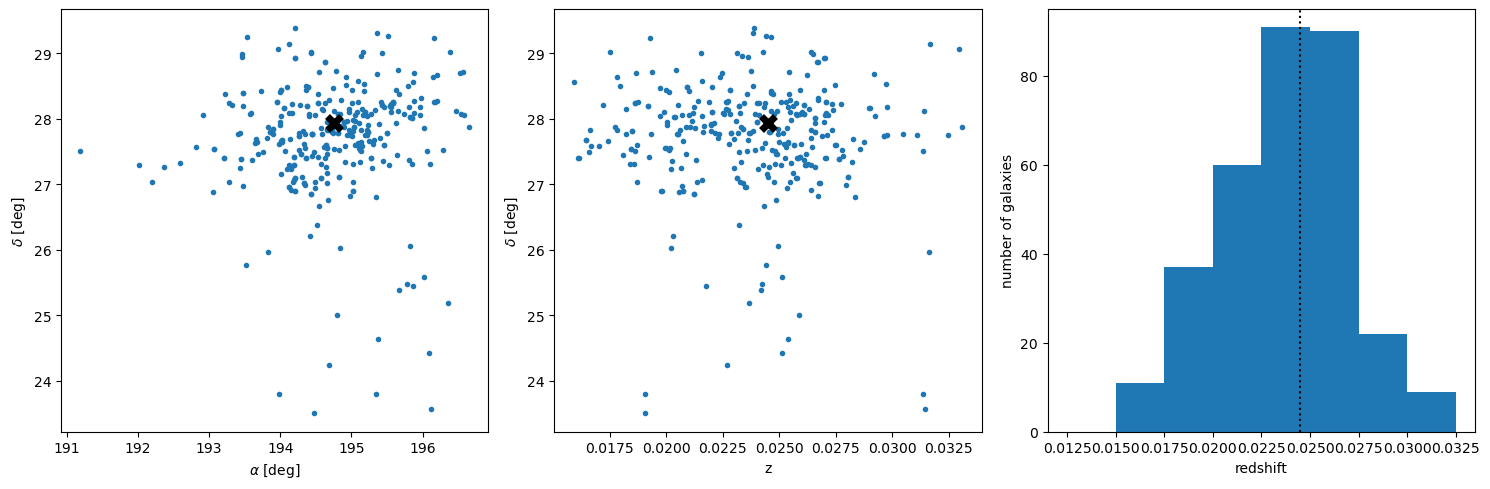

In [17]:
plt.figure(figsize=(15,5), tight_layout=True)

plt.subplot(131)
plt.plot(centers_inComa['TARGET_RA'], centers_inComa['TARGET_DEC'], '.')
plt.plot(Coma_coords.transform_to('icrs').ra.deg, Coma_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.xlabel(r'$\alpha$ [deg]')
plt.ylabel(r'$\delta$ [deg]')

plt.subplot(132)
plt.plot(centers_inComa['Z'], centers_inComa['TARGET_DEC'], '.')
plt.plot(V_Coma/c, Coma_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.xlabel('z')
plt.ylabel(r'$\delta$ [deg]')

plt.subplot(133)
plt.hist(centers_inComa['Z'], bins=np.arange(0.0125, 0.035, 0.0025))
plt.vlines(V_Coma/c, 0, 100, colors='k', linestyles='dotted')
plt.xlabel('redshift')
plt.ylabel('number of galaxies')
plt.ylim(ymax=95);

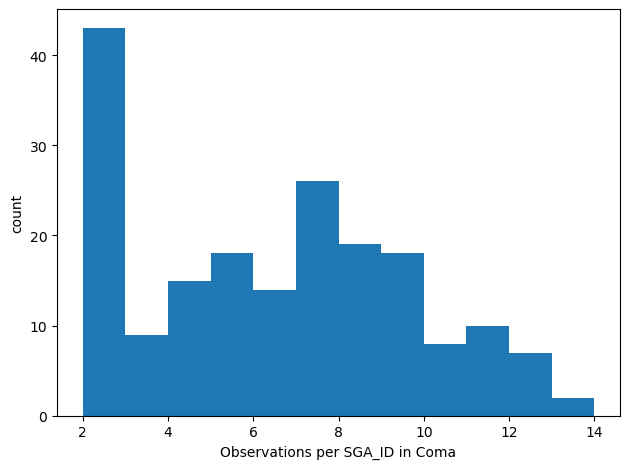

In [18]:
axis_SGAids, axis_counts = np.unique(axis_inComa['SGA_ID'], return_counts=True)
center_SGAids, center_counts = np.unique(centers_inComa['SGA_ID'], return_counts=True)

counts = []

for sga_id in SGA_ID_in_Coma:
    
    center_count = 0
    axis_count = 0
    
    if sga_id in center_SGAids:
        
        center_count = center_counts[center_SGAids == sga_id]
        
    if sga_id in axis_SGAids:
        
        axis_count = axis_counts[axis_SGAids == sga_id]
        
    count = center_count + axis_count
    
    if count > 1:
        
        counts.append(count)
        

plt.figure(tight_layout=True)

plt.hist(np.array(counts), bins=np.arange(2,15))

plt.xlabel('Observations per SGA_ID in Coma')
plt.ylabel('count');

# 0-pt calibrators

Which objects with center observations also have independent distances?

In [19]:
distances = (SGA['DM_Stellar'] != -1) | (SGA['DM1_SN'] != -1) #| np.isfinite(SGA['DM_PantheonSH0ES'])
centers = np.isfinite(SGA['Z_DESI'])

################################################################################
# Keep all observations of each galaxy that have independent distances
#-------------------------------------------------------------------------------
SGA_ID_dist = SGA['SGA_ID'][distances & centers]

centers_dist = good_centers[np.in1d(good_centers['SGA_ID'], SGA_ID_dist)]

axis_dist = fuji_axis[np.in1d(fuji_axis['SGA_ID'], SGA_ID_dist)]
################################################################################

print('fuji galaxies with distances and good center observations:', len(np.unique(centers_dist['SGA_ID'])))
print('fuji off-center observations in galaxies with distances:', len(axis_dist))

fuji galaxies with distances and good center observations: 11
fuji off-center observations in galaxies with distances: 25


# Calculate the rotational velocity

## For Coma galaxies

In [20]:
axis_inComa['SKY_FIBER_DIST'] = 0.
axis_inComa['SKY_FIBER_DIST_R26'] = 0.
axis_inComa['V_ROT'] = np.nan
axis_inComa['V_ROT_ERR'] = np.nan


# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in np.unique(centers_inComa['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = axis_inComa['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center
    #---------------------------------------------------------------------------
    center_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                             dec=SGA['DEC'][sga_idx], 
                             unit=u.degree)
    target_coords = SkyCoord(ra=axis_inComa['RA'][obs_idx], 
                             dec=axis_inComa['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(center_coords)
    
    axis_inComa['SKY_FIBER_DIST'][obs_idx] = sep2d
    axis_inComa['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center = np.mean(SGA['Z_DESI'][sga_idx])
    z_err_center2 = SGA['ZERR_DESI'][sga_idx]**2

    # Calculate rotational velocity for all observations of the galaxy
    axis_inComa['V_ROT'][obs_idx] = c*(axis_inComa['Z'][obs_idx] - z_center)
    axis_inComa['V_ROT_ERR'][obs_idx] = c*np.sqrt(axis_inComa['ZERR'][obs_idx]**2 + z_err_center2)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    axis_inComa['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

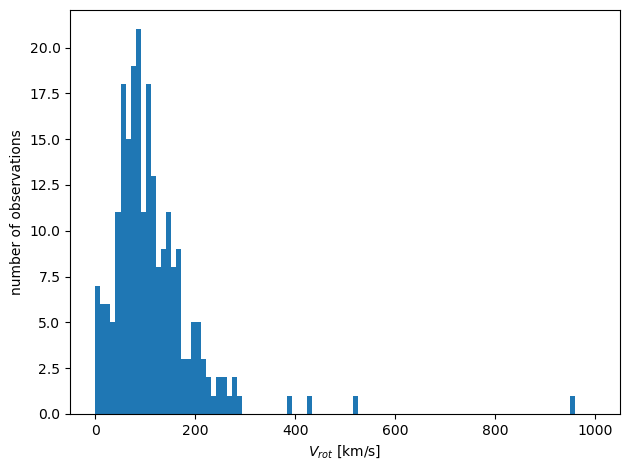

In [21]:
plt.figure(tight_layout=True)

plt.hist(np.abs(axis_inComa['V_ROT']), bins=np.linspace(0, 1000, 100))

plt.xlabel('$V_{rot}$ [km/s]')
plt.ylabel('number of observations');

## For 0-pt calibrators

In [22]:
axis_dist['SKY_FIBER_DIST'] = 0.
axis_dist['SKY_FIBER_DIST_R26'] = 0.
axis_dist['V_ROT'] = np.nan
axis_dist['V_ROT_ERR'] = np.nan


# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in np.unique(centers_dist['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = axis_dist['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center
    #---------------------------------------------------------------------------
    center_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                             dec=SGA['DEC'][sga_idx], 
                             unit=u.degree)
    target_coords = SkyCoord(ra=axis_dist['RA'][obs_idx], 
                             dec=axis_dist['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(center_coords)
    
    axis_dist['SKY_FIBER_DIST'][obs_idx] = sep2d
    axis_dist['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center = np.mean(SGA['Z_DESI'][sga_idx])
    z_err_center2 = SGA['ZERR_DESI'][sga_idx]**2

    # Calculate rotational velocity for all observations of the galaxy
    axis_dist['V_ROT'][obs_idx] = c*(axis_dist['Z'][obs_idx] - z_center)
    axis_dist['V_ROT_ERR'][obs_idx] = c*np.sqrt(axis_dist['ZERR'][obs_idx]**2 + z_err_center2)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    axis_dist['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

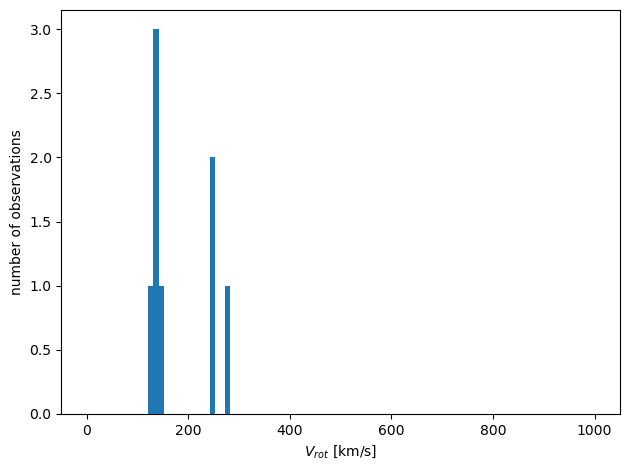

In [23]:
plt.figure(tight_layout=True)

plt.hist(np.abs(axis_dist['V_ROT']), bins=np.linspace(0, 1000, 100))

plt.xlabel('$V_{rot}$ [km/s]')
plt.ylabel('number of observations');

# Cut for galaxies suitable for calibrating the TFR

Requirements:
 * $10 < V_{rot} < 1000$ km/s at $0.33R_{26}$
 * $\Delta V / V_{min} \leq 5$
 * $i > 45^\circ$
 * Spiral-type morphology
 * Passes visual inspection

## Velocity cut

In [24]:
r0p3 = (axis_inComa['SKY_FIBER_DIST_R26'] > 0.3) & (axis_inComa['SKY_FIBER_DIST_R26'] < 0.4)

Vgood = (np.abs(axis_inComa['V_ROT']) < 1000) & (np.abs(axis_inComa['V_ROT']) > 10)

good_axis_inComa = axis_inComa[r0p3 & Vgood]

print(len(good_axis_inComa), len(np.unique(good_axis_inComa['SGA_ID'])))

193 113


In [25]:
r0p3_0pt = (axis_dist['SKY_FIBER_DIST_R26'] > 0.3) & (axis_dist['SKY_FIBER_DIST_R26'] < 0.4)

Vgood_0pt = (np.abs(axis_dist['V_ROT']) < 1000) & (np.abs(axis_dist['V_ROT']) > 10)

good_axis_dist = axis_dist[r0p3_0pt & Vgood_0pt]

print(len(good_axis_dist), len(np.unique(good_axis_dist['SGA_ID'])))

7 3


## Relative velocity cut

In [26]:
good_deltaV = np.ones(len(good_axis_inComa), dtype=bool)

for sga_id in np.unique(good_axis_inComa['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_axis_inComa['SGA_ID'] == sga_id
    
    n_obs = np.sum(obs_idx)
    
    if n_obs > 1:
        
        Vmin = np.min(np.abs(good_axis_inComa['V_ROT'][obs_idx]))
        Vmax = np.max(np.abs(good_axis_inComa['V_ROT'][obs_idx]))
        
        v_norm_min = np.abs(good_axis_inComa['V_ROT'][obs_idx])/Vmin
        v_norm_max = np.abs(good_axis_inComa['V_ROT'][obs_idx])/Vmax
        
        diff_matrix = np.abs(good_axis_inComa['V_ROT'][obs_idx]).reshape(n_obs, 1) - np.abs(good_axis_inComa['V_ROT'][obs_idx]).reshape(1, n_obs)
        
        diff_matrix_norm = diff_matrix/Vmin
        
        if np.any(np.abs(diff_matrix_norm) > 5.):
            
            # Remove all observations with DELTACHI2 < 25
            # Note: This also typically removes observations with ZWARN != 0
            deltachi2_idx = good_axis_inComa['DELTACHI2'] >= 25
            
            good_deltaV[obs_idx & ~deltachi2_idx] = False
            
            good_obs_idx = obs_idx & deltachi2_idx
            
            n_obs_good = np.sum(good_obs_idx)
            
            # Check to make sure that, if there are still multiple observations, they all satisfy our relative velocity criteria
            if n_obs_good > 1:
                
                Vmin = np.min(np.abs(good_axis_inComa['V_ROT'][good_obs_idx]))
                
                diff_matrix = np.abs(good_axis_inComa['V_ROT'][good_obs_idx]).reshape(n_obs_good, 1) - np.abs(good_axis_inComa['V_ROT'][good_obs_idx]).reshape(1, n_obs_good)
                
                diff_matrix_norm = diff_matrix/Vmin
                
                if np.any(np.abs(diff_matrix_norm) > 5.):
                    
                    # Set all of these so that we don't look at this galaxy
                    good_deltaV[good_obs_idx] = False

In [27]:
good_deltaV_axis_inComa = good_axis_inComa[good_deltaV]

print(len(good_deltaV_axis_inComa), len(np.unique(good_deltaV_axis_inComa['SGA_ID'])))

185 110


In [28]:
good_deltaV_0pt = np.ones(len(good_axis_dist), dtype=bool)

for sga_id in np.unique(good_axis_dist['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_axis_dist['SGA_ID'] == sga_id
    
    n_obs = np.sum(obs_idx)
    
    if n_obs > 1:
        
        Vmin = np.min(np.abs(good_axis_dist['V_ROT'][obs_idx]))
        Vmax = np.max(np.abs(good_axis_dist['V_ROT'][obs_idx]))
        
        v_norm_min = np.abs(good_axis_dist['V_ROT'][obs_idx])/Vmin
        v_norm_max = np.abs(good_axis_dist['V_ROT'][obs_idx])/Vmax
        
        diff_matrix = np.abs(good_axis_dist['V_ROT'][obs_idx]).reshape(n_obs, 1) - np.abs(good_axis_dist['V_ROT'][obs_idx]).reshape(1, n_obs)
        
        diff_matrix_norm = diff_matrix/Vmin
        
        if np.any(np.abs(diff_matrix_norm) > 5.):
            
            # Remove all observations with DELTACHI2 < 25
            # Note: This also typically removes observations with ZWARN != 0
            deltachi2_idx = good_axis_dist['DELTACHI2'] >= 25
            
            good_deltaV_0pt[obs_idx & ~deltachi2_idx] = False
            
            good_obs_idx = obs_idx & deltachi2_idx
            
            n_obs_good = np.sum(good_obs_idx)
            
            # Check to make sure that, if there are still multiple observations, they all satisfy our relative velocity criteria
            if n_obs_good > 1:
                
                Vmin = np.min(np.abs(good_axis_dist['V_ROT'][good_obs_idx]))
                
                diff_matrix = np.abs(good_axis_dist['V_ROT'][good_obs_idx]).reshape(n_obs_good, 1) - np.abs(good_axis_dist['V_ROT'][good_obs_idx]).reshape(1, n_obs_good)
                
                diff_matrix_norm = diff_matrix/Vmin
                
                if np.any(np.abs(diff_matrix_norm) > 5.):
                    
                    # Set all of these so that we don't look at this galaxy
                    good_deltaV_0pt[good_obs_idx] = False

In [29]:
good_deltaV_axis_dist = good_axis_dist[good_deltaV_0pt]

print(len(good_deltaV_axis_dist), len(np.unique(good_deltaV_axis_dist['SGA_ID'])))

7 3


## Inclination angle cut

In [30]:
SGA['cosi2'] = (SGA['BA']**2 - q0**2)/(1 - q0**2)
SGA['cosi2'][SGA['cosi2'] < 0] = 0

i_min = 45. # degrees
cosi2_max = np.cos(i_min*np.pi/180.)**2

In [31]:
good_deltaV_axis_inComa['iSGA'] = -1

for i in range(len(good_deltaV_axis_inComa)):
    
    # Find galaxy in SGA
    sga_idx = SGA_dict[good_deltaV_axis_inComa['SGA_ID'][i]]
    
    good_deltaV_axis_inComa['iSGA'][i] = sga_idx
    
good_deltaV_axis_inComa['cosi2'] = SGA['cosi2'][good_deltaV_axis_inComa['iSGA']]

In [32]:
edge = good_deltaV_axis_inComa['cosi2'] <= cosi2_max

good_edge_axis_inComa = good_deltaV_axis_inComa[edge]

print(len(good_edge_axis_inComa), len(np.unique(good_edge_axis_inComa['SGA_ID'])))

150 91


In [33]:
good_deltaV_axis_dist['iSGA'] = -1

for i in range(len(good_deltaV_axis_dist)):
    
    # Find galaxy in SGA
    sga_idx = SGA_dict[good_deltaV_axis_dist['SGA_ID'][i]]
    
    good_deltaV_axis_dist['iSGA'][i] = sga_idx
    
good_deltaV_axis_dist['cosi2'] = SGA['cosi2'][good_deltaV_axis_dist['iSGA']]

In [34]:
edge_0pt = good_deltaV_axis_dist['cosi2'] <= cosi2_max

good_edge_axis_dist = good_deltaV_axis_dist[edge_0pt]

print(len(good_edge_axis_dist), len(np.unique(good_edge_axis_dist['SGA_ID'])))

6 2


## Morphology cut

In [35]:
good_edge_axis_inComa['MORPHTYPE'] = SGA['MORPHTYPE'][good_edge_axis_inComa['iSGA']]

In [36]:
spirals = np.zeros(len(good_edge_axis_inComa), dtype=bool)

for i in range(len(good_edge_axis_inComa)):
    
    try:    
        if (good_edge_axis_inComa['MORPHTYPE'][i][0] == 'S') and (good_edge_axis_inComa['MORPHTYPE'][i][:2] != 'S0'):
            spirals[i] = True
    except IndexError:
        print(good_edge_axis_inComa['MORPHTYPE'][i])

good_edge_spirals_axis_inComa = good_edge_axis_inComa[spirals]

print(len(good_edge_spirals_axis_inComa), len(np.unique(good_edge_spirals_axis_inComa['SGA_ID'])))

80 45


In [37]:
good_edge_axis_dist['MORPHTYPE'] = SGA['MORPHTYPE'][good_edge_axis_dist['iSGA']]

In [38]:
spirals_0pt = np.zeros(len(good_edge_axis_dist), dtype=bool)

for i in range(len(good_edge_axis_dist)):
    
    try:    
        if (good_edge_axis_dist['MORPHTYPE'][i][0] == 'S') and (good_edge_axis_dist['MORPHTYPE'][i][:2] != 'S0'):
            spirals_0pt[i] = True
        elif good_edge_axis_dist['MORPHTYPE'][i] == 'N/A':
            spirals_0pt[i] = True
    except IndexError:
        print(good_edge_axis_dist['MORPHTYPE'][i])

good_edge_spirals_axis_dist = good_edge_axis_dist[spirals_0pt]

print(len(good_edge_spirals_axis_dist), len(np.unique(good_edge_spirals_axis_dist['SGA_ID'])))

6 2


## Visual inspection cut

This removes any observations that are contaminated by foreground stars or other galaxies.

In [36]:
def get_cutout(targetid, ra, dec, size, verbose=False):
    """Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    targetid : int
        DESI target ID.
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    w : astropy.wcs.WCS
        World coordinate system for the image.
    """
    # Either load an existing image or download a cutout.
    img_name = 'cache/coma_{}.jpg'.format(targetid)
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        img_url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra={}&dec={}&zoom=14&layer=ls-dr9&size={}&sga'.format(ra, dec, size)
        if verbose:
            print('Get {}'.format(img_url))
            
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
                
    # Set up the WCS.
    wcs_input_dict = {
        'CTYPE1': 'RA---TAN',
        'CUNIT1': 'deg',
        'CDELT1': -0.262/3600,
        'CRPIX1': size/2 + 0.5,
        'CRVAL1': ra,
        'NAXIS1': size,
        'CTYPE2': 'DEC--TAN',
        'CUNIT2': 'deg',
        'CDELT2': 0.262/3600,
        'CRPIX2': size/2 + 0.5,
        'CRVAL2': dec,
        'NAXIS2': size
    }
    w = WCS(wcs_input_dict)
    
    return img_name, w

In [37]:
for sga_id in np.unique(good_edge_spirals_axis_inComa['SGA_ID']):
    
    tf_list = good_edge_spirals_axis_inComa[good_edge_spirals_axis_inComa['SGA_ID'] == sga_id]
    center_list = centers_inComa[centers_inComa['SGA_ID'] == sga_id]
    
    try:
        targetid = int(center_list['TARGETID'][0])
    except TypeError as err:
        print(err)
        # print(sga_galaxy['TARGETID'])
        continue
    
    ra, dec, z = float(SGA['RA'][SGA_dict[sga_id]]), float(SGA['DEC'][SGA_dict[sga_id]]), float(SGA['Z_DESI'][SGA_dict[sga_id]])
    
    # D26 in arcmin
    d26 = SGA['D26'][SGA_dict[sga_id]]
    
    # Padd the image cutout of the galaxy.
    # Multiply by 60 (to arcsec), divide by 180 to get pixscale.
#     pixscale = 1.05*d26*60/180
    npix = np.minimum(int(1.025 * d26*60/0.262), 512)
    
    #print(targetid, sga_id, ra, dec)
#     img_file = get_cutout(targetid, ra, dec, size=npix, verbose=True)
    img_file, wcs = get_cutout(targetid, ra, dec, size=npix, verbose=True)
    img = mpl.image.imread(img_file)

    fig1 = plt.figure(figsize=(7,5))

    ax = fig1.add_subplot(111, projection=wcs)
    ax.imshow(np.flip(img, axis=0))
    ax.set(xlabel='ra', ylabel='dec')
    ax.text(int(0.02*npix), int(0.85*npix), 'TARGETID: {}\nSGA_ID: {}\n$z={{{:.4f}}}$'.format(targetid, sga_id, z), fontsize=9, color='yellow')
    overlay = ax.get_coords_overlay('icrs')
    overlay.grid(color='white', ls='dotted');

    # Add the location of the DESI fibers.
    # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
    r1 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                         edgecolor='black', facecolor='none', alpha=0.8, lw=3,
                         transform=ax.get_transform('icrs'))
    r2 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                         edgecolor='red', facecolor='none', alpha=0.8, lw=2,
                         transform=ax.get_transform('icrs'))
    ax.add_patch(r1)
    ax.add_patch(r2)

    for tft in tf_list:
        ra, dec = tft['RA'], tft['DEC']
        
        edgecolor2 = 'orange'
#         if tft['Z'] > 0.05:
#             edgecolor2 = 'orange'
#         else:
#             edgecolor2 = 'lime'
        
        # Add the location of the DESI fibers.
        # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
        r1 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                             edgecolor='lightcoral', facecolor='none', alpha=1, lw=3,
                             transform=ax.get_transform('icrs'))
        r2 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                             edgecolor=edgecolor2, facecolor='none', alpha=0.8, lw=2,
                             transform=ax.get_transform('icrs'))
        ax.add_patch(r1)
        ax.add_patch(r2)
        
        ax.text(ra, dec, str(tft['TARGETID']), transform=ax.get_transform('icrs'), color='white')
    
    fig1.subplots_adjust(top=0.85, right=0.85, bottom=0.15, left=0.15)
    
    fig1.savefig('cache/fuji_VI_cutouts/dist_{}.png'.format(sga_id), dpi=120)
    
    fig1.clear()
    plt.close(fig1)
    '''
    #----------------------------------------------------------------------------------
    # Get spectra
    #----------------------------------------------------------------------------------
    coadds = get_spectra_for_sga(good_edge_spirals_axis_inComa, sga_id)
    n = coadds.num_spectra()

    fig2, axes = plt.subplots(n,1, figsize=(8,4*n), sharex=True, sharey=True, tight_layout=True)

    for i in range(n):
        wave = coadds.wave['brz']
        flux = coadds.flux['brz'][i]
        smoothed = gaussian_filter1d(flux, 7)

        ax = axes[i]
        ax.plot(wave, smoothed, label='TARGETID: {}'.format(coadds.fibermap['TARGETID'][i]))
        ax.set(ylabel=r'flux [$10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]')
        if i+1 == n:
            ax.set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]')

        ax.legend(loc='upper right', fontsize=10)
    
    # figure = PdfPages('cache/DM_cutouts/dist_{}.pdf'.format(sga_id))
    # figure.savefig(fig1, dpi = 300)
    # figure.savefig(fig2, dpi = 120)
    # figure.close()
    
    break
    ''';

Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=195.97667146704435&dec=28.31062379047577&zoom=14&layer=ls-dr9&size=185&sga
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=195.04313321875534&dec=27.959071290945204&zoom=14&layer=ls-dr9&size=110&sga
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=194.20691376173056&dec=27.093895925073287&zoom=14&layer=ls-dr9&size=328&sga
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=195.84774376778842&dec=27.30687826270548&zoom=14&layer=ls-dr9&size=104&sga
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=194.57594096774397&dec=27.848482700176607&zoom=14&layer=ls-dr9&size=159&sga
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=193.63830652599466&dec=27.63275185427826&zoom=14&layer=ls-dr9&size=348&sga
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=195.21296726515683&dec=27.742983900813208&zoom=14&layer=ls-dr9&size=177&sga
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=193.06742023100352&dec=27.5331587436960

In [39]:
VI_remove = Table.read('fuji_VI.txt', format='ascii.commented_header')

remove_targets = np.zeros(len(good_edge_spirals_axis_inComa), dtype=bool)

for targetid in VI_remove['TARGETID']:
    
    remove_targets = remove_targets & (good_edge_spirals_axis_inComa['TARGETID'] == targetid)
    
VI_good_edge_spirals_axis_inComa = good_edge_spirals_axis_inComa[~remove_targets]

print(len(VI_good_edge_spirals_axis_inComa), len(np.unique(VI_good_edge_spirals_axis_inComa['SGA_ID'])))

80 45


Both of the 0-pt calibrators pass VI.

# Coma TFR

## Compute the weighted average velocity for those galaxies with more than one observation at $0.33R_{26}$:

\begin{equation}
  \overline{v} = \frac{\sum_i w_i v_i}{\sum_i w_i}
\end{equation}
where $w_i = 1/\sigma^2$.

In [40]:
SGA['V_0p33R26'] = np.nan
SGA['V_0p33R26_err'] = np.nan

weights = 1./(VI_good_edge_spirals_axis_inComa['V_ROT_ERR']**2)

for sga_id in np.unique(VI_good_edge_spirals_axis_inComa['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = VI_good_edge_spirals_axis_inComa['SGA_ID'] == sga_id
    
    SGA['V_0p33R26'][SGA_dict[sga_id]] = np.average(np.abs(VI_good_edge_spirals_axis_inComa['V_ROT'][obs_idx]), 
                                                    weights=weights[obs_idx])

    SGA['V_0p33R26_err'][SGA_dict[sga_id]] = np.sqrt(1./np.sum(weights[obs_idx]))

In [41]:
# Make a catalog of just Coma galaxies with velocities
SGA_TF = SGA[np.isfinite(SGA['V_0p33R26']) & (SGA['R_MAG_SB26'] > 0)]

In [42]:
SGA['V_0p33R26'] = np.nan
SGA['V_0p33R26_err'] = np.nan

good_edge_spirals_axis_dist['R_MAG_SB26'] = np.nan
good_edge_spirals_axis_dist['R_MAG_SB26_ERR'] = np.nan

weights = 1./(good_edge_spirals_axis_dist['V_ROT_ERR']**2)

for sga_id in np.unique(good_edge_spirals_axis_dist['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_edge_spirals_axis_dist['SGA_ID'] == sga_id
    
    SGA['V_0p33R26'][SGA_dict[sga_id]] = np.average(np.abs(good_edge_spirals_axis_dist['V_ROT'][obs_idx]), 
                                                    weights=weights[obs_idx])

    SGA['V_0p33R26_err'][SGA_dict[sga_id]] = np.sqrt(1./np.sum(weights[obs_idx]))

In [43]:
# Make a catalog of just 0-pt galaxies with velocities
SGA_0pt = SGA[np.isfinite(SGA['V_0p33R26']) & (SGA['R_MAG_SB26'] > 0)]

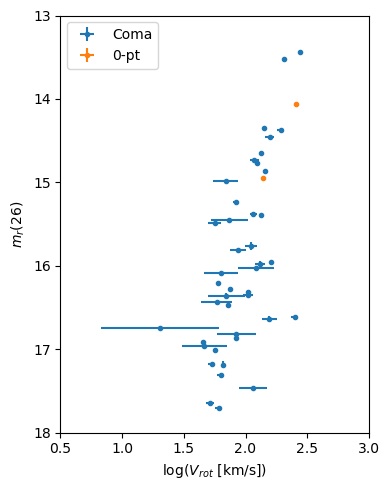

In [44]:
plt.figure(figsize=(4,5), tight_layout=True)

plt.errorbar(np.log10(SGA_TF['V_0p33R26']), 
             SGA_TF['R_MAG_SB26'], 
             xerr=0.434*SGA_TF['V_0p33R26_err']/SGA_TF['V_0p33R26'],
             yerr=SGA_TF['R_MAG_SB26_ERR'], 
             fmt='.', 
             label='Coma')

plt.errorbar(np.log10(SGA_0pt['V_0p33R26']), 
             SGA_0pt['R_MAG_SB26'], 
             xerr=0.434*SGA_0pt['V_0p33R26_err']/SGA_0pt['V_0p33R26'],
             yerr=SGA_0pt['R_MAG_SB26_ERR'], 
             fmt='.', 
             label='0-pt')

plt.xlim([0.5, 3])
plt.ylim([18, 13])

plt.legend()

plt.xlabel('log($V_{rot}$ [km/s])')
plt.ylabel('$m_r (26)$');

# Compute the absolute magnitudes for the 0-pt calibrators based on the distance measurements

\begin{equation}
  M_r - 5\log h = m_r - \mu - 5\log h
\end{equation}
where $h$ is the reduced Hubble constant used to calibrate the distance modulus, $\mu$.

Both of our galaxies have distance moduli from Stahl et al. (2021), which *appears* to use $h = 1$.  Therefore, the distance moduli we have to use are $\mu_h = \mu - 5\log h$.

The third galaxy has a distance moduli from Pantheon+SH0ES, whose distances are based on distance ladder calibrations, so there is no assumption of $h$.

In [45]:
SGA_0pt['R_ABSMAG_SB26'] = SGA_0pt['R_MAG_SB26'] - SGA_0pt['DM1_SN'] #+ 5*np.log10(0.7)
SGA_0pt['R_ABSMAG_SB26_err'] = np.sqrt(SGA_0pt['R_MAG_SB26_ERR']**2 + SGA_0pt['e_DM1_SN']**2)

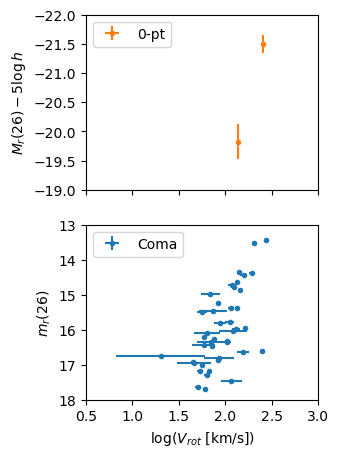

In [46]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(3,5))

ax2.errorbar(np.log10(SGA_TF['V_0p33R26']), 
             SGA_TF['R_MAG_SB26'], 
             xerr=0.434*SGA_TF['V_0p33R26_err']/SGA_TF['V_0p33R26'],
             yerr=SGA_TF['R_MAG_SB26_ERR'], 
             fmt='.', 
             label='Coma')

ax1.errorbar(np.log10(SGA_0pt['V_0p33R26']), 
             SGA_0pt['R_ABSMAG_SB26'], 
             xerr=0.434*SGA_0pt['V_0p33R26_err']/SGA_0pt['V_0p33R26'],
             yerr=SGA_0pt['R_ABSMAG_SB26_err'], 
             fmt='.', 
             c='tab:orange',
             label='0-pt')

plt.xlim([0.5, 3])
ax1.set_ylim([-19, -22])
ax2.set_ylim([18, 13])

ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

plt.xlabel('log($V_{rot}$ [km/s])')
ax1.set_ylabel('$M_r (26) - 5\log h$')
ax2.set_ylabel('$m_r (26)$');

# Fit the TFR using the hacked version of `hyperfit`

In [47]:
V0 = np.median(np.concatenate([np.log10(SGA_TF['V_0p33R26']), np.log10(SGA_0pt['V_0p33R26'])]))
print(V0)

1.9789831722918412


In [71]:
# bounds_tfr = ((-20.0, 0.0), (0.0, 20.0), (-30.0, 0.0), (1.0e-5, 5.0))
bounds_itfr = ((-20.0, 20.0), (0.0, 20.0), (-20.0, 0.0), (1.0e-5, 5.0))

results = hyperfit_line_multi([SGA_TF['R_MAG_SB26'], SGA_0pt['R_ABSMAG_SB26']],
                              [np.log10(SGA_TF['V_0p33R26']) - V0, np.log10(SGA_0pt['V_0p33R26']) - V0], 
                              [SGA_TF['R_MAG_SB26_ERR'], SGA_0pt['R_ABSMAG_SB26_err']], 
                              [0.434*SGA_TF['V_0p33R26_err']/SGA_TF['V_0p33R26'], 0.434*SGA_0pt['V_0p33R26_err']/SGA_0pt['V_0p33R26']], 
                              bounds_itfr)

w0, w1, sig_w, cov_w, itfr_mcmc_samples, hf_itfr = results

     fun: -2394.1313135549008
     jac: array([ 0.91245056,  0.39835868,  0.43164619, -0.1886292 ])
 message: 'Optimization terminated successfully.'
    nfev: 4795
     nit: 78
 success: True
       x: array([-0.12813382,  2.04803462, -2.33953298,  0.14052622])


100%|██████████| 1000/1000 [00:01<00:00, 572.13it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [26.84803942 27.24858267 26.4831565  34.37435556] / 1718.7177779638428


100%|██████████| 1000/1000 [00:01<00:00, 574.48it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [32.65893288 32.89138845 32.97743253 41.766469  ] / 2088.323450034791


100%|██████████| 1000/1000 [00:01<00:00, 575.84it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [41.17026931 40.59681546 41.45078015 48.85283956] / 2442.64197811021


100%|██████████| 1000/1000 [00:01<00:00, 573.13it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [46.69604327 46.63235919 47.74368814 42.80836161] / 2387.18440688425


100%|██████████| 1000/1000 [00:01<00:00, 574.81it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [46.12855312 45.9284796  47.34200596 45.49675401] / 2367.1002979191735


100%|██████████| 1000/1000 [00:01<00:00, 574.91it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [48.66704699 48.10477437 48.32909865 45.42161973] / 2433.3523493573107


100%|██████████| 1000/1000 [00:01<00:00, 575.39it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [48.45491886 48.23654595 48.66177953 42.00419111] / 2433.088976348003


100%|██████████| 1000/1000 [00:01<00:00, 574.27it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [51.25718435 51.37242359 51.26312433 41.2568532 ] / 2568.621179547396


100%|██████████| 1000/1000 [00:01<00:00, 574.64it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [54.56978568 54.9566303  53.92518469 42.66197457] / 2747.831515142227


100%|██████████| 1000/1000 [00:01<00:00, 573.41it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [57.91314019 57.99445871 56.99412049 45.54857951] / 2899.722935400496


100%|██████████| 1000/1000 [00:01<00:00, 574.35it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [52.09907946 52.5959236  50.57786987 44.1970437 ] / 2629.796179955285


100%|██████████| 1000/1000 [00:01<00:00, 573.40it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [51.02212524 51.55362076 49.84734022 45.11983181] / 2577.6810381219275


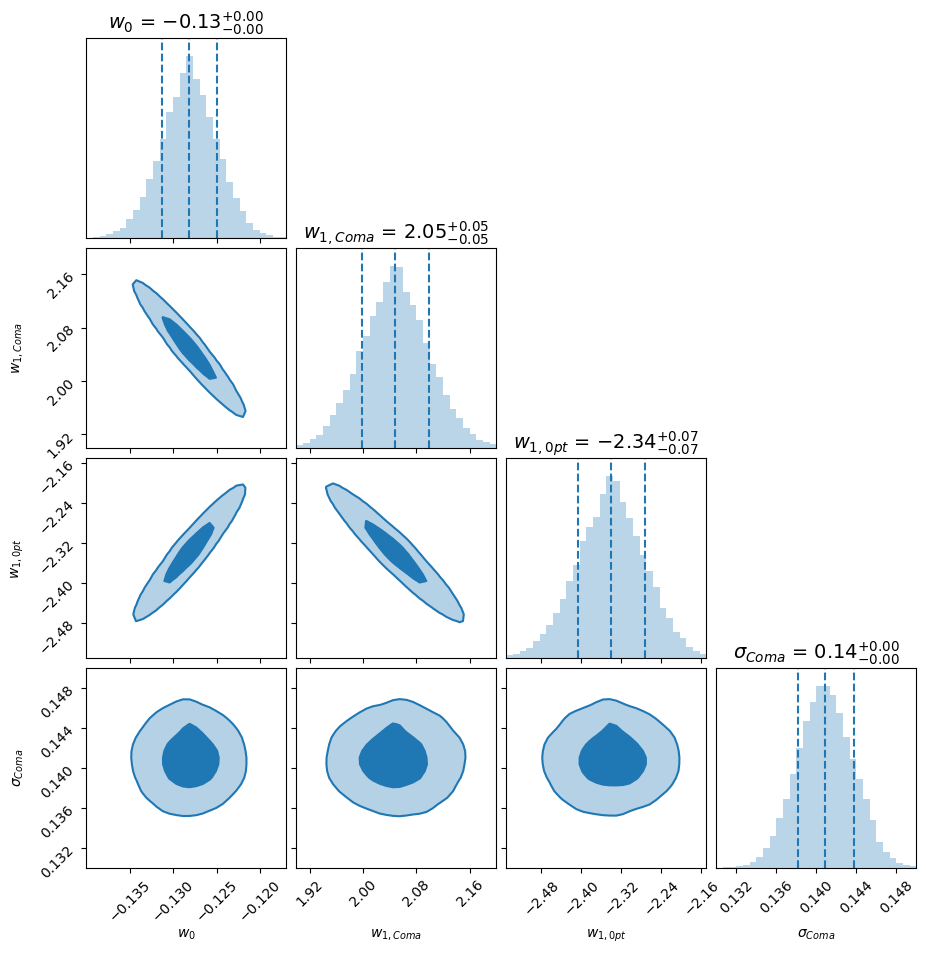

In [49]:
fig = corner.corner(itfr_mcmc_samples.T, bins=30, smooth=1,
                    range=[[-0.14, -0.117], [1.9, 2.2], [-2.55, -2.15], [0.13, 0.15]],   # Range for w0, w1, sigma. Adjust as needed.
                    # range=[[-8.4, -7.2], [15.85, 16.1], [-18.6, -17.8], [1, 1.2]], # Range for a, b, sigma.  Adjust as needed.
                    labels=['$w_0$', '$w_{1, Coma}$', '$w_{1, 0 pt}$', r'$\sigma_{Coma}$'],
                    # labels=['$a$', '$b_{Coma}$', '$b_{0 pt}$', r'$\sigma$'],
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)),
                    quantiles=[0.16, 0.5, 0.84],
                    color='tab:blue',
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    plot_datapoints=False,
                    fill_contours=True,
                    show_titles=True,
                    title = {'Joint fit of Coma and 0-pt calibrators'},
                    title_kwargs={"fontsize": 14});

In [50]:
a_itfr, b_itfr, cov_itfr = param_invert(w0, w1, cov_w[:3,:3])

print(f'              w0: {w0:.3f} +/- {np.sqrt(cov_w[0,0]):.3f}')
print(f'         w1 Coma:  {w1[0]:.2f}  +/- {np.sqrt(cov_w[1,1]):.2f}')
print(f'          w1 0pt: {w1[1]:.2f}  +/- {np.sqrt(cov_w[2,2]):.2f}')
print(f'           slope: {a_itfr:.2f}  +/- {np.sqrt(cov_itfr[0,0]):.2f}')
print(f'y-intercept Coma:  {b_itfr[0]:.2f} +/- {np.sqrt(cov_itfr[1,1]):.2f}')
print(f' y-intercept 0pt: {b_itfr[1]:.2f} +/- {np.sqrt(cov_itfr[2,2]):.2f}')

              w0: -0.128 +/- 0.003
         w1 Coma:  2.05  +/- 0.05
          w1 0pt: -2.34  +/- 0.07
           slope: -7.80  +/- 0.20
y-intercept Coma:  15.98 +/- 0.03
 y-intercept 0pt: -18.26 +/- 0.12


### Plot the Hyperfit

After the linear fit MCMC, construct the bestfit line and its 1-sigma uncertainties.

Also plot the measurements as ellipses with the size given by the uncertainties in log(v) and $m_r$, and the color given by the best-fit scatter parameter $\sigma_i$.

Code taken from plotting examples in [hyperfit documentation](https://hyperfit.readthedocs.io/en/latest/tutorial.html#a-simple-best-fit).

In [51]:
# Invert the MCMC samples so that they represent (a, b) and not (w0, w1)
tfr_mcmc_samples = np.zeros(itfr_mcmc_samples.shape)

tfr_mcmc_samples[0] = 1./itfr_mcmc_samples[0]
tfr_mcmc_samples[1] = -itfr_mcmc_samples[1]/itfr_mcmc_samples[0]
tfr_mcmc_samples[2] = -itfr_mcmc_samples[2]/itfr_mcmc_samples[0]
tfr_mcmc_samples[3] = itfr_mcmc_samples[3]

In [52]:
# temp_outfile = open('mcmc_fuji_Coma_ITFR_KAD-V0_' + str(V0) + '.pickle', 'wb')
# pickle.dump((cov_w, cov_itfr, itfr_mcmc_samples, tfr_mcmc_samples), temp_outfile)
# temp_outfile.close()

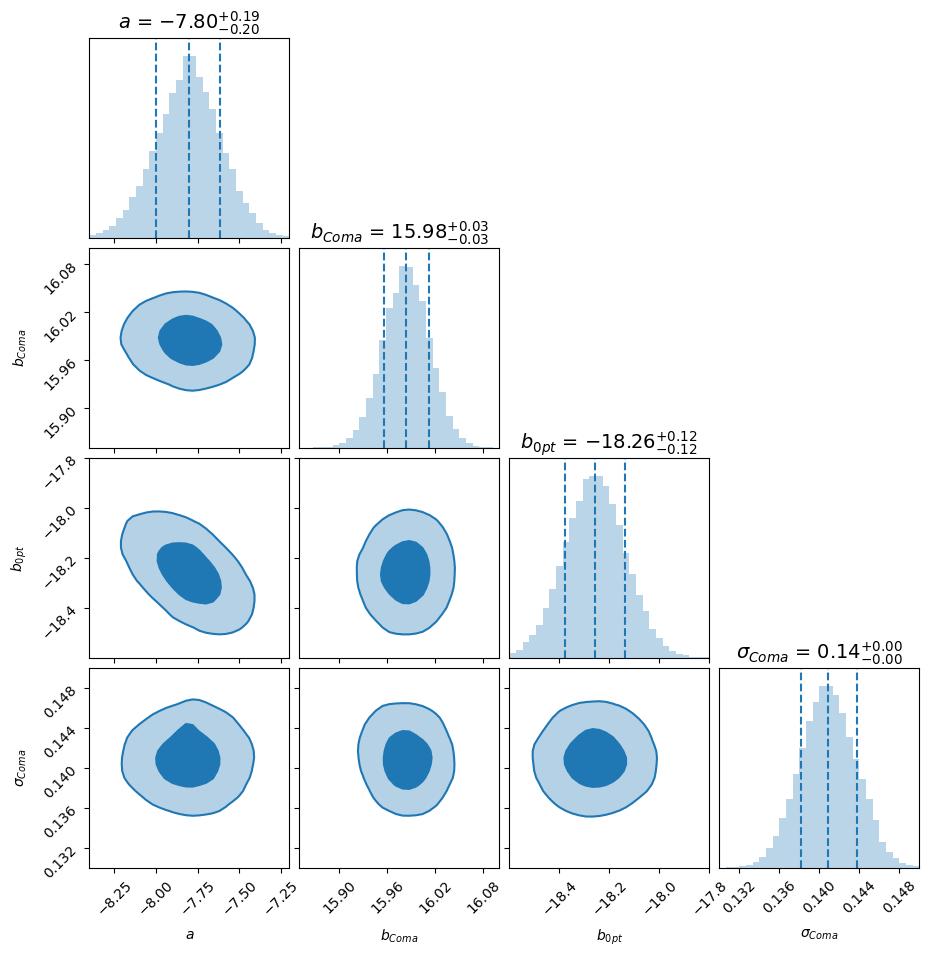

In [53]:
fig = corner.corner(tfr_mcmc_samples.T, bins=30, smooth=1,
                    # range=[[-12, -4], [10, 13.5], [0.05, 0.25]],   # Range for a, b, sigma. Adjust as needed.
                    # range=[[-12, -4], [15, 17], [0.05, 0.25]], # V0 = 2.0
                    # range=[[-12, -4], [12, 15], [0.05, 0.25]], # V0 = 2.25
                    # range=[[-12, -4], [17, 19], [0.05, 0.25]], # V0 = 1.75
                    range=[[-8.4, -7.2], [15.85, 16.1], [-18.6, -17.8], [0.13, 0.15]],
                    labels=['$a$', '$b_{Coma}$', '$b_{0pt}$', r'$\sigma_{Coma}$'],
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)),
                    quantiles=[0.16, 0.5, 0.84],
                    color='tab:blue',
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    plot_datapoints=False,
                    fill_contours=True,
                    show_titles=True,
                    title = {'Joint fit of Coma and 0-pt calibrators'},
                    title_kwargs={"fontsize": 14})

# fig.savefig('../../Figures/SV/fuji_Coma_corner_20240130.png', dpi=150)

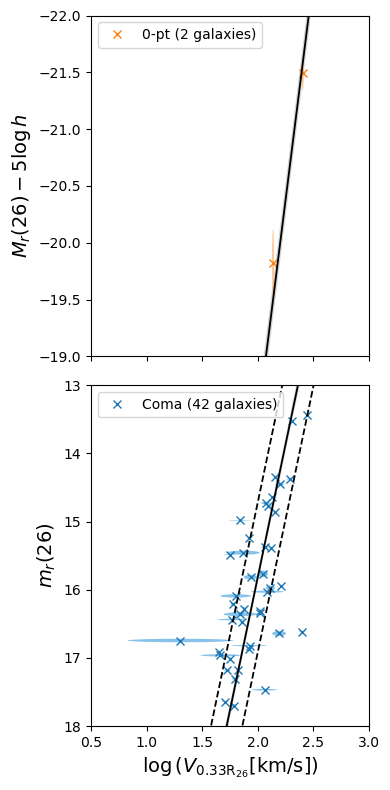

In [54]:
xvals = np.linspace(1., 3., 1000)
yvals = np.zeros((len(b_itfr), len(xvals)))
for i in range(len(b_itfr)):
    yvals[i] = a_itfr * (xvals - V0) + b_itfr[i]

################################################################################
# Get the MCMC 1-sigma quantiles to plot with the fit.
#-------------------------------------------------------------------------------
y_chain1 = np.outer(xvals - V0, tfr_mcmc_samples[0]) + tfr_mcmc_samples[1]
y_chain1_quantiles = np.quantile(y_chain1, [0.1587, 0.8414], axis=1)

y_chain2 = np.outer(xvals - V0, tfr_mcmc_samples[0]) + tfr_mcmc_samples[2]
y_chain2_quantiles = np.quantile(y_chain2, [0.1587, 0.8414], axis=1)
################################################################################


################################################################################
# Pack info into data
#-------------------------------------------------------------------------------
data1 = [np.log10(SGA_TF['V_0p33R26']), SGA_TF['R_MAG_SB26']]
x1_err = 0.434*SGA_TF['V_0p33R26_err']/SGA_TF['V_0p33R26']
y1_err = SGA_TF['R_MAG_SB26_ERR']
corr1_xy = np.zeros_like(x1_err)

data2 = [np.log10(SGA_0pt['V_0p33R26']), SGA_0pt['R_ABSMAG_SB26']]
x2_err = 0.434*SGA_0pt['V_0p33R26_err']/SGA_0pt['V_0p33R26']
y2_err = SGA_0pt['R_ABSMAG_SB26_err']
corr2_xy = np.zeros_like(x2_err)
################################################################################


################################################################################
# Generate ellipses
#-------------------------------------------------------------------------------
ells1 = [
    Ellipse(
        xy=[data1[0][i], data1[1][i]],
        width=2*y1_err[i],
        height=2*x1_err[i],
        angle=np.rad2deg(np.arccos(corr1_xy[i])),
    )
    for i in range(len(data1[0]))
]

ells2 = [
    Ellipse(
        xy=[data2[0][i], data2[1][i]],
        width=2*y2_err[i],
        height=2*x2_err[i],
        angle=np.rad2deg(np.arccos(corr2_xy[i])),
    )
    for i in range(len(data2[0]))
]
################################################################################


################################################################################
# Make the plot
#-------------------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(2, figsize=(4,8), tight_layout=True, sharex=True)

#-------------------------------------------------------------------------------
# Coma
#-------------------------------------------------------------------------------
ax2.fill_between(xvals, 
                 y_chain1_quantiles[0], 
                 y_chain1_quantiles[1], 
                 color="lightgray")

for i, e in enumerate(ells1):
    ax2.add_artist(e)
    #e.set_edgecolor('None')
    e.set_facecolor(adjust_lightness('tab:blue', amount=1.75))
    
ax2.plot(data1[0], data1[1], 'x', label='Coma ({} galaxies)'.format(len(SGA_TF)))

ax2.plot(xvals, yvals[0], c="k", marker="None", ls="-", lw=1.3)
ax2.plot(xvals - sig_w[0], yvals[0], c="k", marker="None", ls="--", lw=1.3)
ax2.plot(xvals + sig_w[0], yvals[0], c="k", marker="None", ls="--", lw=1.3)

ax2.set_xlabel(r"$\log{(V_\mathrm{0.33R_{26}} [\mathrm{km/s}])}$", fontsize=14)
ax2.set_ylabel(r"$m_r(26)$", fontsize=14)

ax2.legend(loc='upper left')

plt.xlim(0.5, 3)
ax2.set_ylim(18, 13)
#-------------------------------------------------------------------------------
# 0-pt calibrators
#-------------------------------------------------------------------------------
ax1.fill_between(xvals, 
                 y_chain2_quantiles[0], 
                 y_chain2_quantiles[1], 
                 color='lightgray')

for i, e in enumerate(ells2):
    ax1.add_artist(e)
    e.set_facecolor(adjust_lightness('tab:orange', amount=1.25))
    
ax1.plot(data2[0], 
         data2[1], 
         'x', 
         c='tab:orange',
         label='0-pt ({} galaxies)'.format(len(SGA_0pt)))

ax1.plot(xvals, yvals[1], c='k', marker='None', ls='-', lw=1.3)

ax1.set_ylabel(r'$M_r (26) - 5\log h$', fontsize=14)

ax1.legend(loc='upper left')

ax1.set_ylim(-19, -22);
#-------------------------------------------------------------------------------
################################################################################

# plt.savefig('../../Figures/SV/fuji_Coma_TFR_20240130.png', dpi=150)

# Does this calibration result in any dwarf galaxies?

Dwarf galaxies are defined as those with $M_r > -17$.

## Calculate the absolute magnitudes for the galaxies based on the current TF calibration

\begin{equation}
  M_r = a(\log \left( V(0.33R_{26}) \right) - V_0) + b
\end{equation}

In [65]:
SGA_TF['R_ABSMAG_SB26'] = a_itfr*(np.log10(SGA_TF['V_0p33R26']) - V0) + b_itfr[1]

In [68]:
rng = np.random.default_rng()

m_random = tfr_mcmc_samples[0]
b_random = tfr_mcmc_samples[2]

N_samples = len(m_random)

SGA_TF['R_ABSMAG_SB26_err'] = np.nan

for i in range(len(SGA_TF)):
    
    v_random = rng.normal(SGA_TF['V_0p33R26'][i], SGA_TF['V_0p33R26_err'][i], size=N_samples)
    
    Ms = m_random*(np.log10(v_random) - V0) + b_random
    
    SGA_TF['R_ABSMAG_SB26_err'][i] = np.nanstd(Ms)

/tmp/ipykernel_2153320/436680262.py:14: RuntimeWarning: invalid value encountered in log10
  Ms = m_random*(np.log10(v_random) - V0) + b_random


## Filter out the dwarf galaxies

Those with $M_r > -17$

In [69]:
dwarfs = (SGA_TF['R_ABSMAG_SB26'] - SGA_TF['R_ABSMAG_SB26_err']) > -17

SGA_TF_bright = SGA_TF[~dwarfs]

print(np.sum(dwarfs))

8


Looks like we have 8 "dwarf" galaxies, so we will need to repeat the calibration without these.

# 1st recalibration

Using the `dwarfs` sample

In [72]:
results_bright = hyperfit_line_multi([SGA_TF_bright['R_MAG_SB26'], SGA_0pt['R_ABSMAG_SB26']],
                                     [np.log10(SGA_TF_bright['V_0p33R26']) - V0, np.log10(SGA_0pt['V_0p33R26']) - V0], 
                                     [SGA_TF_bright['R_MAG_SB26_ERR'], SGA_0pt['R_ABSMAG_SB26_err']], 
                                     [0.434*SGA_TF_bright['V_0p33R26_err']/SGA_TF_bright['V_0p33R26'], 0.434*SGA_0pt['V_0p33R26_err']/SGA_0pt['V_0p33R26']], 
                                     bounds_itfr)

w0_bright, w1_bright, sig_w_bright, cov_w_bright, itfr_mcmc_samples_bright, hf_itfr_bright = results_bright

     fun: -1663.7427543634565
     jac: array([0.00081855, 0.19861091, 0.28269369, 0.10181793])
 message: 'Optimization terminated successfully.'
    nfev: 5745
     nit: 94
 success: True
       x: array([-0.10814986,  1.76803961, -1.9177722 ,  0.12841671])


100%|██████████| 1000/1000 [00:01<00:00, 574.15it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [34.6346897  34.50469883 34.3253159  41.7111432 ] / 2085.5571598778433


100%|██████████| 1000/1000 [00:01<00:00, 573.60it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [37.47134879 37.91907609 36.88065084 39.78134144] / 1989.0670720324526


100%|██████████| 1000/1000 [00:01<00:00, 571.22it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [40.71604606 40.65965151 41.47365609 40.99457929] / 2073.6828044345075


100%|██████████| 1000/1000 [00:01<00:00, 571.75it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [41.56040262 40.96128957 39.65221905 44.67279105] / 2233.6395525667185


100%|██████████| 1000/1000 [00:01<00:00, 571.68it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [45.81543362 45.29006692 45.92947499 48.82491799] / 2441.245899682324


100%|██████████| 1000/1000 [00:01<00:00, 573.07it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [46.83155738 46.50690721 47.0267046  44.24602684] / 2351.335229887865


100%|██████████| 1000/1000 [00:01<00:00, 574.46it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [46.03679346 45.85135336 47.15895513 49.27077678] / 2463.538839248213


100%|██████████| 1000/1000 [00:01<00:00, 563.42it/s]

Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [46.46590103 46.56677234 48.18046887 49.46460825] / 2473.230412674693


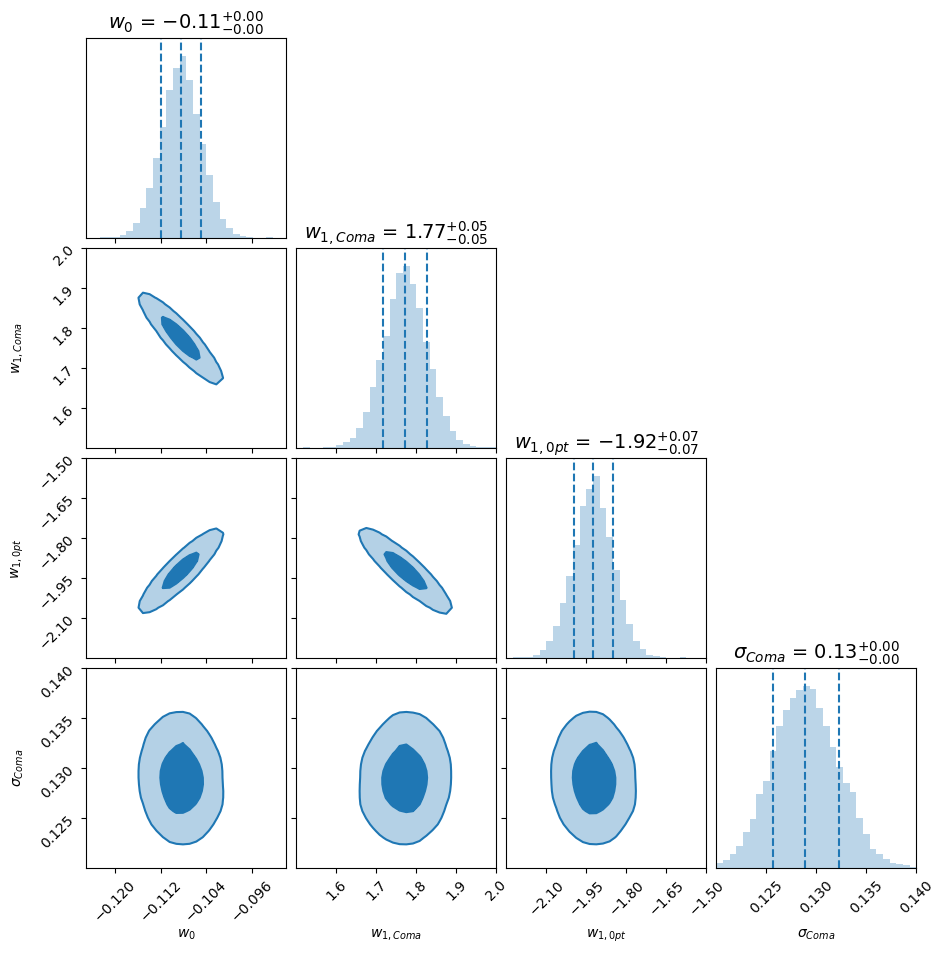

In [75]:
fig = corner.corner(itfr_mcmc_samples_bright.T, bins=30, smooth=1,
                    range=[[-0.125, -0.09], [1.5, 2.0], [-2.25, -1.5], [0.12, 0.14]],   # Range for w0, w1, sigma. Adjust as needed.
                    labels=['$w_0$', '$w_{1, Coma}$', '$w_{1, 0 pt}$', r'$\sigma_{Coma}$'],
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)),
                    quantiles=[0.16, 0.5, 0.84],
                    color='tab:blue',
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    plot_datapoints=False,
                    fill_contours=True,
                    show_titles=True,
                    title = {'Joint fit of Coma and 0-pt calibrators'},
                    title_kwargs={"fontsize": 14});

In [76]:
a_itfr_bright, b_itfr_bright, cov_itfr_bright = param_invert(w0_bright, w1_bright, cov_w_bright[:3,:3])

print(f'              w0: {w0_bright:.3f} +/- {np.sqrt(cov_w_bright[0,0]):.3f}')
print(f'         w1 Coma:  {w1_bright[0]:.2f}  +/- {np.sqrt(cov_w_bright[1,1]):.2f}')
print(f'          w1 0pt: {w1_bright[1]:.2f}  +/- {np.sqrt(cov_w_bright[2,2]):.2f}')
print(f'           slope: {a_itfr_bright:.2f}  +/- {np.sqrt(cov_itfr_bright[0,0]):.2f}')
print(f'y-intercept Coma:  {b_itfr_bright[0]:.2f} +/- {np.sqrt(cov_itfr_bright[1,1]):.2f}')
print(f' y-intercept 0pt: {b_itfr_bright[1]:.2f} +/- {np.sqrt(cov_itfr_bright[2,2]):.2f}')

              w0: -0.108 +/- 0.003
         w1 Coma:  1.77  +/- 0.05
          w1 0pt: -1.92  +/- 0.08
           slope: -9.22  +/- 0.30
y-intercept Coma:  16.34 +/- 0.05
 y-intercept 0pt: -17.74 +/- 0.16


In [77]:
# Invert the MCMC samples so that they represent (a, b) and not (w0, w1)
tfr_mcmc_samples_bright = np.zeros(itfr_mcmc_samples_bright.shape)

tfr_mcmc_samples_bright[0] = 1./itfr_mcmc_samples_bright[0]
tfr_mcmc_samples_bright[1] = -itfr_mcmc_samples_bright[1]/itfr_mcmc_samples_bright[0]
tfr_mcmc_samples_bright[2] = -itfr_mcmc_samples_bright[2]/itfr_mcmc_samples_bright[0]
tfr_mcmc_samples_bright[3] = itfr_mcmc_samples_bright[3]

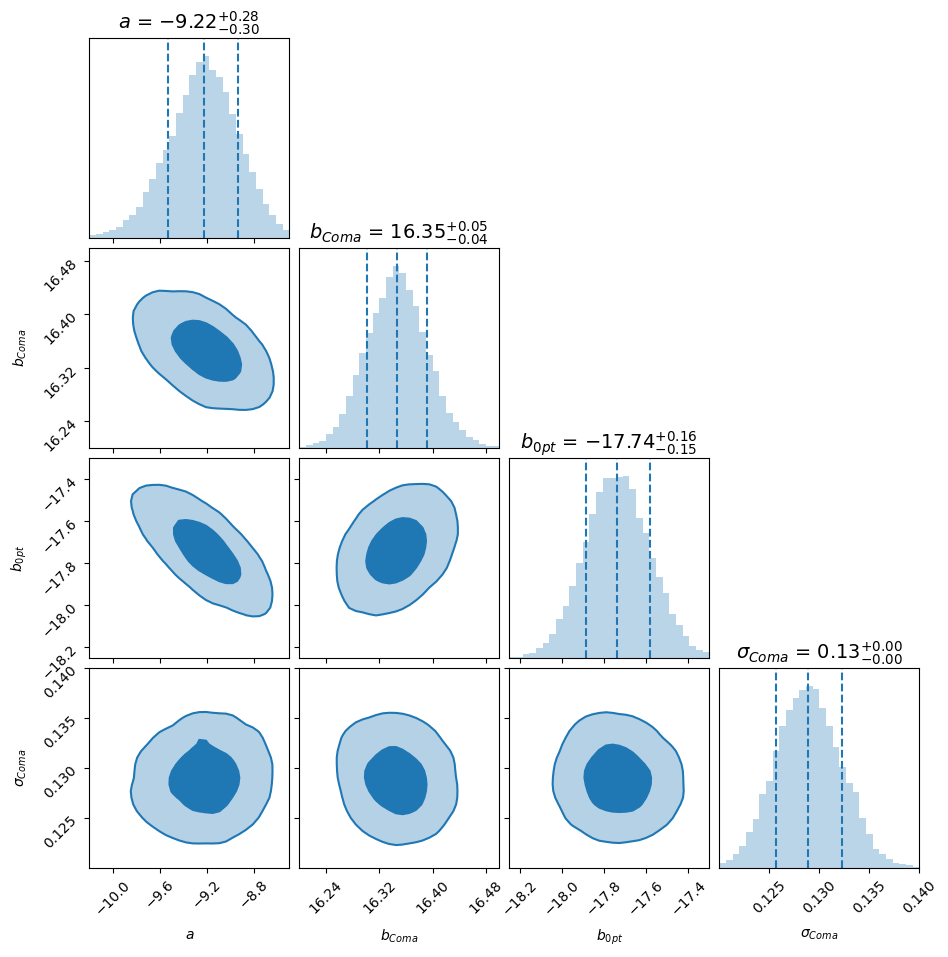

In [82]:
fig = corner.corner(tfr_mcmc_samples_bright.T, bins=30, smooth=1,
                    range=[[-10.2, -8.5], [16.2, 16.5], [-18.25, -17.3], [0.12, 0.14]],
                    labels=['$a$', '$b_{Coma}$', '$b_{0pt}$', r'$\sigma_{Coma}$'],
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)),
                    quantiles=[0.16, 0.5, 0.84],
                    color='tab:blue',
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    plot_datapoints=False,
                    fill_contours=True,
                    show_titles=True,
                    title = {'Joint fit of Coma and 0-pt calibrators'},
                    title_kwargs={"fontsize": 14})

# fig.savefig('../../Figures/SV/fuji_Coma_corner_20240130.png', dpi=150)

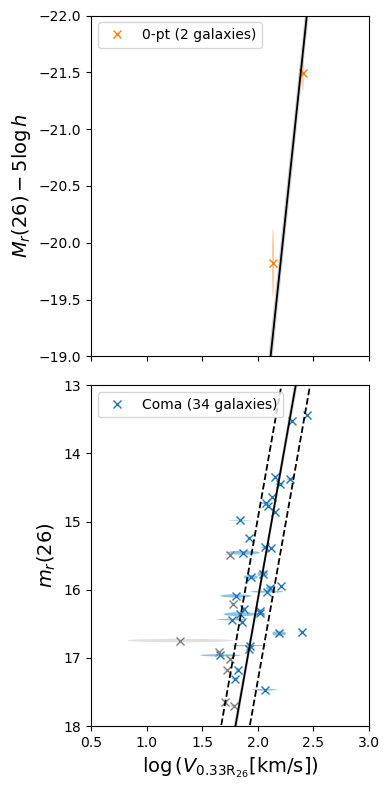

In [86]:
yvals_bright = np.zeros((len(b_itfr_bright), len(xvals)))
for i in range(len(b_itfr_bright)):
    yvals_bright[i] = a_itfr_bright * (xvals - V0) + b_itfr_bright[i]

################################################################################
# Get the MCMC 1-sigma quantiles to plot with the fit.
#-------------------------------------------------------------------------------
y_chain1_bright = np.outer(xvals - V0, tfr_mcmc_samples_bright[0]) + tfr_mcmc_samples_bright[1]
y_chain1_bright_quantiles = np.quantile(y_chain1_bright, [0.1587, 0.8414], axis=1)

y_chain2_bright = np.outer(xvals - V0, tfr_mcmc_samples_bright[0]) + tfr_mcmc_samples_bright[2]
y_chain2_bright_quantiles = np.quantile(y_chain2_bright, [0.1587, 0.8414], axis=1)
################################################################################


################################################################################
# Pack info into data
#-------------------------------------------------------------------------------
data1_bright = [np.log10(SGA_TF_bright['V_0p33R26']), SGA_TF_bright['R_MAG_SB26']]
x1_bright_err = 0.434*SGA_TF_bright['V_0p33R26_err']/SGA_TF_bright['V_0p33R26']
y1_bright_err = SGA_TF_bright['R_MAG_SB26_ERR']
corr1_xy_bright = np.zeros_like(x1_bright_err)

# Removed galaxies
data1_removed = [np.log10(SGA_TF['V_0p33R26'][dwarfs]), SGA_TF['R_MAG_SB26'][dwarfs]]
x1_err_removed = 0.434*SGA_TF['V_0p33R26_err'][dwarfs]/SGA_TF['V_0p33R26'][dwarfs]
y1_err_removed = SGA_TF['R_MAG_SB26_ERR'][dwarfs]
corr1_xy_removed = np.zeros_like(x1_err_removed)

# data2 is the same as the first fit
################################################################################


################################################################################
# Generate ellipses
#-------------------------------------------------------------------------------
ells1_bright = [
                Ellipse(
                    xy=[data1_bright[0][i], data1_bright[1][i]],
                    width=2*y1_bright_err[i],
                    height=2*x1_bright_err[i],
                    angle=np.rad2deg(np.arccos(corr1_xy_bright[i])),
                )
                for i in range(len(data1_bright[0]))
]

ells1_removed = [
                 Ellipse(
                     xy=[data1_removed[0][i], data1_removed[1][i]], 
                     width=2*y1_err_removed[i], 
                     height=2*x1_err_removed[i], 
                     angle=np.rad2deg(np.arccos(corr1_xy_removed[i])), 
                 )
    for i in range(len(data1_removed[0]))
]

# ells2 is the same as the first fit, but matplotlib won't let us reuse it
ells2_bright = [
                Ellipse(
                    xy=[data2[0][i], data2[1][i]],
                    width=2*y2_err[i],
                    height=2*x2_err[i],
                    angle=np.rad2deg(np.arccos(corr2_xy[i])),
                )
                for i in range(len(data2[0]))
]
################################################################################


################################################################################
# Make the plot
#-------------------------------------------------------------------------------
fig_bright, (ax1_bright, ax2_bright) = plt.subplots(2, 
                                                    figsize=(4,8), 
                                                    tight_layout=True, 
                                                    sharex=True)

#-------------------------------------------------------------------------------
# Coma
#-------------------------------------------------------------------------------
ax2_bright.fill_between(xvals, 
                        y_chain1_bright_quantiles[0], 
                        y_chain1_bright_quantiles[1], 
                        color="lightgray")

for i, e in enumerate(ells1_bright):
    ax2_bright.add_artist(e)
    #e.set_edgecolor('None')
    e.set_facecolor(adjust_lightness('tab:blue', amount=1.75))
for i, e in enumerate(ells1_removed):
    ax2_bright.add_artist(e)
    e.set_facecolor(adjust_lightness('gray', amount=1.75))
    
ax2_bright.plot(data1_bright[0], data1_bright[1], 'x', 
                label='Coma ({} galaxies)'.format(len(SGA_TF_bright)))
ax2_bright.plot(data1_removed[0], data1_removed[1], 'x', c='gray')

ax2_bright.plot(xvals, yvals_bright[0], c="k", marker="None", ls="-", lw=1.3)
ax2_bright.plot(xvals - sig_w_bright[0], yvals_bright[0], 
                c="k", marker="None", ls="--", lw=1.3)
ax2_bright.plot(xvals + sig_w_bright[0], yvals_bright[0], 
                c="k", marker="None", ls="--", lw=1.3)

ax2_bright.set_xlabel(r"$\log{(V_\mathrm{0.33R_{26}} [\mathrm{km/s}])}$", 
                      fontsize=14)
ax2_bright.set_ylabel(r"$m_r(26)$", fontsize=14)

ax2_bright.legend(loc='upper left')

plt.xlim(0.5, 3)
ax2_bright.set_ylim(18, 13)
#-------------------------------------------------------------------------------
# 0-pt calibrators
#-------------------------------------------------------------------------------
ax1_bright.fill_between(xvals, 
                        y_chain2_bright_quantiles[0], 
                        y_chain2_bright_quantiles[1], 
                        color='lightgray')

for i, e in enumerate(ells2_bright):
    ax1_bright.add_artist(e)
    e.set_facecolor(adjust_lightness('tab:orange', amount=1.25))
    
ax1_bright.plot(data2[0], 
                data2[1], 
                'x', 
                c='tab:orange',
                label='0-pt ({} galaxies)'.format(len(SGA_0pt)))

ax1_bright.plot(xvals, yvals_bright[1], c='k', marker='None', ls='-', lw=1.3)

ax1_bright.set_ylabel(r'$M_r (26) - 5\log h$', fontsize=14)

ax1_bright.legend(loc='upper left')

ax1_bright.set_ylim(-19, -22);
#-------------------------------------------------------------------------------
################################################################################

# plt.savefig('../../Figures/SV/fuji_Coma_TFR_20240130.png', dpi=150)

# Does this calibration result in any dwarf galaxies?

## Calculate the absolute magnitudes for the galaxies based on the current TF calibration

In [87]:
SGA_TF['R_ABSMAG_SB26_bright'] = a_itfr_bright*(np.log10(SGA_TF['V_0p33R26']) - V0) + b_itfr_bright[1]

In [88]:
m2_random = tfr_mcmc_samples_bright[0]
b2_random = tfr_mcmc_samples_bright[2]

N_samples = len(m2_random)

SGA_TF['R_ABSMAG_SB26_bright_err'] = np.nan

for i in range(len(SGA_TF)):
    
    v_random = rng.normal(SGA_TF['V_0p33R26'][i], SGA_TF['V_0p33R26_err'][i], size=N_samples)
    
    Ms = m2_random*(np.log10(v_random) - V0) + b2_random
    
    SGA_TF['R_ABSMAG_SB26_bright_err'][i] = np.nanstd(Ms)

/tmp/ipykernel_2153320/2281974380.py:12: RuntimeWarning: invalid value encountered in log10
  Ms = m2_random*(np.log10(v_random) - V0) + b2_random


In [89]:
dwarfs2 = (SGA_TF['R_ABSMAG_SB26_bright'] - SGA_TF['R_ABSMAG_SB26_bright_err']) > -17

SGA_TF_bright2 = SGA_TF[~dwarfs2]

print(np.sum(dwarfs2))

11


Looks like we now have 11 "dwarf" galaxies, so we will need to repeat the calibration without these.

# 2nd recalibration

Using the `dwarfs2` sample

In [90]:
results_bright2 = hyperfit_line_multi([SGA_TF_bright2['R_MAG_SB26'], SGA_0pt['R_ABSMAG_SB26']],
                                      [np.log10(SGA_TF_bright2['V_0p33R26']) - V0, np.log10(SGA_0pt['V_0p33R26']) - V0], 
                                      [SGA_TF_bright2['R_MAG_SB26_ERR'], SGA_0pt['R_ABSMAG_SB26_err']], 
                                      [0.434*SGA_TF_bright2['V_0p33R26_err']/SGA_TF_bright2['V_0p33R26'], 0.434*SGA_0pt['V_0p33R26_err']/SGA_0pt['V_0p33R26']], 
                                      bounds_itfr)

w0_bright2, w1_bright2, sig_w_bright2, cov_w_bright2, itfr_mcmc_samples_bright2, hf_itfr_bright2 = results_bright2

     fun: -1354.142940518694
     jac: array([-0.8841198 ,  0.52750693,  0.52214091,  1.00226316])
 message: 'Optimization terminated successfully.'
    nfev: 6330
     nit: 104
 success: True
       x: array([-0.09817412,  1.62325972, -1.70729612,  0.13055278])


100%|██████████| 1000/1000 [00:01<00:00, 574.43it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [29.09997888 28.24128284 31.78309917 34.55585311] / 1727.7926557237226


100%|██████████| 1000/1000 [00:01<00:00, 566.53it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [40.28595039 39.73028372 41.68705716 33.84359965] / 2084.352857754469


100%|██████████| 1000/1000 [00:01<00:00, 528.50it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [42.77470663 42.70918536 41.88885206 37.16704691] / 2138.7353312989794


100%|██████████| 1000/1000 [00:01<00:00, 529.74it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [41.54135047 42.19020542 40.80497594 40.98683925] / 2109.510270827929


100%|██████████| 1000/1000 [00:01<00:00, 529.17it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [45.25895206 45.55297911 44.66454862 41.56204105] / 2277.6489556860115


100%|██████████| 1000/1000 [00:01<00:00, 531.44it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [41.66162755 41.77478409 41.87859529 40.8279968 ] / 2093.929764339334


100%|██████████| 1000/1000 [00:01<00:00, 530.57it/s]

Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [41.76483594 42.02269911 41.89081767 42.53274603] / 2126.637301701179


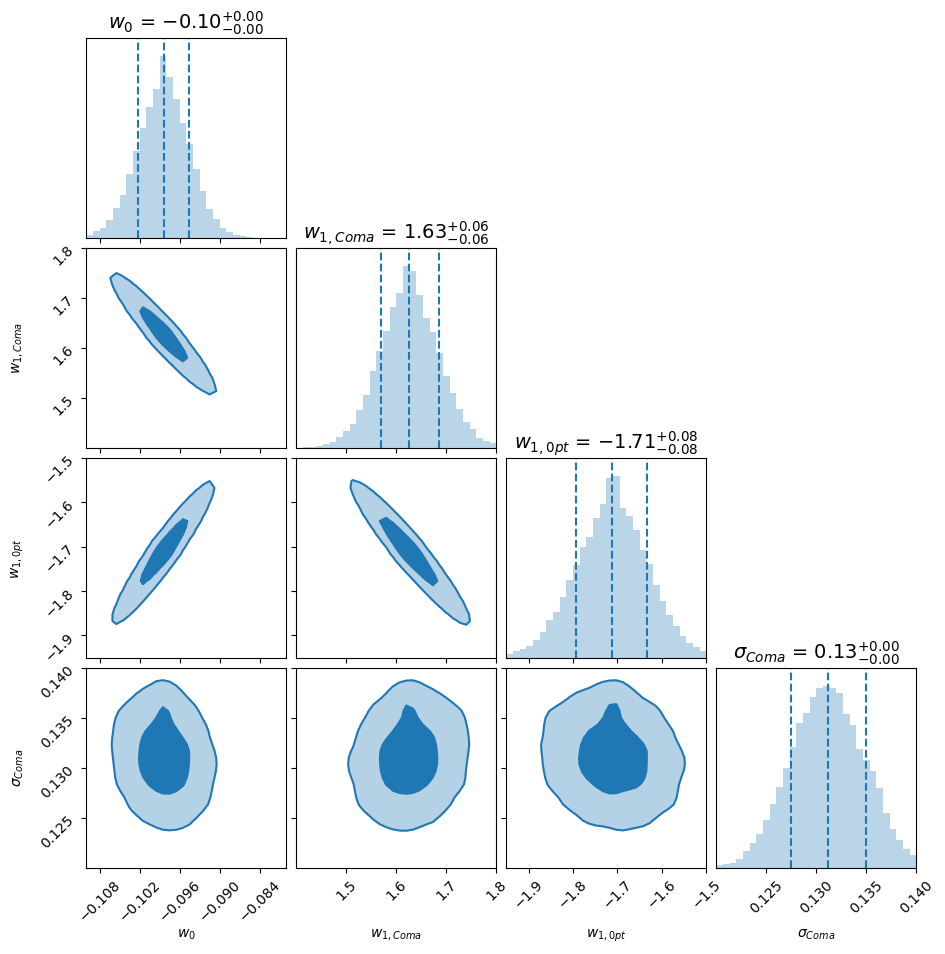

In [93]:
fig = corner.corner(itfr_mcmc_samples_bright2.T, bins=30, smooth=1,
                    range=[[-0.11, -0.08], [1.4, 1.8], [-1.95, -1.5], [0.12, 0.14]],   # Range for w0, w1, sigma. Adjust as needed.
                    labels=['$w_0$', '$w_{1, Coma}$', '$w_{1, 0 pt}$', r'$\sigma_{Coma}$'],
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)),
                    quantiles=[0.16, 0.5, 0.84],
                    color='tab:blue',
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    plot_datapoints=False,
                    fill_contours=True,
                    show_titles=True,
                    title = {'Joint fit of Coma and 0-pt calibrators'},
                    title_kwargs={"fontsize": 14});

In [94]:
a_itfr_bright2, b_itfr_bright2, cov_itfr_bright2 = param_invert(w0_bright2, w1_bright2, cov_w_bright2[:3,:3])

print(f'              w0: {w0_bright2:.3f} +/- {np.sqrt(cov_w_bright2[0,0]):.3f}')
print(f'         w1 Coma:  {w1_bright2[0]:.2f}  +/- {np.sqrt(cov_w_bright2[1,1]):.2f}')
print(f'          w1 0pt: {w1_bright2[1]:.2f}  +/- {np.sqrt(cov_w_bright2[2,2]):.2f}')
print(f'           slope: {a_itfr_bright2:.2f}  +/- {np.sqrt(cov_itfr_bright2[0,0]):.2f}')
print(f'y-intercept Coma:  {b_itfr_bright2[0]:.2f} +/- {np.sqrt(cov_itfr_bright2[1,1]):.2f}')
print(f' y-intercept 0pt: {b_itfr_bright2[1]:.2f} +/- {np.sqrt(cov_itfr_bright2[2,2]):.2f}')

              w0: -0.098 +/- 0.004
         w1 Coma:  1.63  +/- 0.06
          w1 0pt: -1.71  +/- 0.08
           slope: -10.16  +/- 0.40
y-intercept Coma:  16.53 +/- 0.07
 y-intercept 0pt: -17.39 +/- 0.18


In [95]:
# Invert the MCMC samples so that they represent (a, b) and not (w0, w1)
tfr_mcmc_samples_bright2 = np.zeros(itfr_mcmc_samples_bright2.shape)

tfr_mcmc_samples_bright2[0] = 1./itfr_mcmc_samples_bright2[0]
tfr_mcmc_samples_bright2[1] = -itfr_mcmc_samples_bright2[1]/itfr_mcmc_samples_bright2[0]
tfr_mcmc_samples_bright2[2] = -itfr_mcmc_samples_bright2[2]/itfr_mcmc_samples_bright2[0]
tfr_mcmc_samples_bright2[3] = itfr_mcmc_samples_bright2[3]

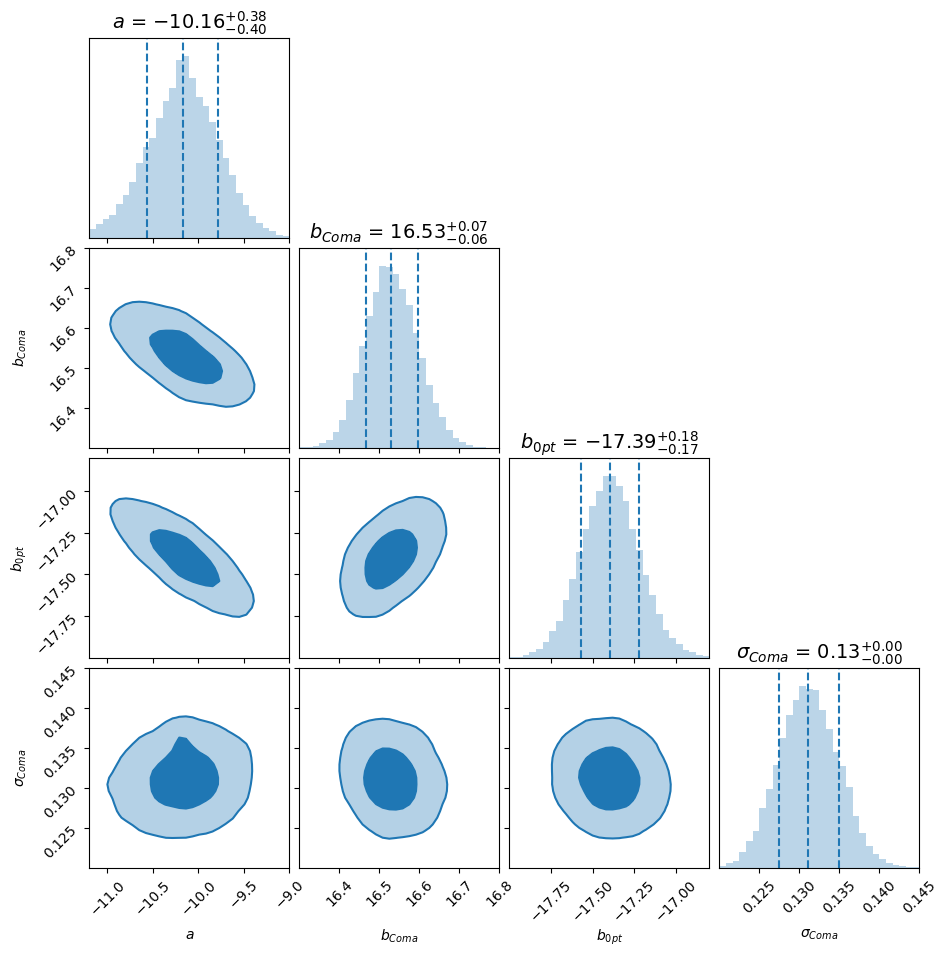

In [99]:
fig = corner.corner(tfr_mcmc_samples_bright2.T, bins=30, smooth=1,
                    range=[[-11.2, -9.0], [16.3, 16.8], [-18.0, -16.8], [0.12, 0.145]],
                    labels=['$a$', '$b_{Coma}$', '$b_{0pt}$', r'$\sigma_{Coma}$'],
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)),
                    quantiles=[0.16, 0.5, 0.84],
                    color='tab:blue',
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    plot_datapoints=False,
                    fill_contours=True,
                    show_titles=True,
                    title = {'Joint fit of Coma and 0-pt calibrators'},
                    title_kwargs={"fontsize": 14})

# fig.savefig('../../Figures/SV/fuji_Coma_corner_20240130.png', dpi=150)

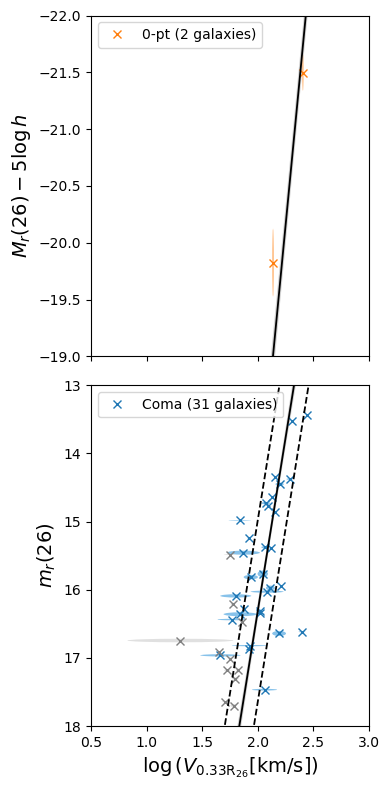

In [100]:
yvals_bright2 = np.zeros((len(b_itfr_bright2), len(xvals)))
for i in range(len(b_itfr_bright2)):
    yvals_bright2[i] = a_itfr_bright2 * (xvals - V0) + b_itfr_bright2[i]

################################################################################
# Get the MCMC 1-sigma quantiles to plot with the fit.
#-------------------------------------------------------------------------------
y_chain1_bright2 = np.outer(xvals - V0, tfr_mcmc_samples_bright2[0]) + tfr_mcmc_samples_bright2[1]
y_chain1_bright2_quantiles = np.quantile(y_chain1_bright2, [0.1587, 0.8414], axis=1)

y_chain2_bright2 = np.outer(xvals - V0, tfr_mcmc_samples_bright2[0]) + tfr_mcmc_samples_bright2[2]
y_chain2_bright2_quantiles = np.quantile(y_chain2_bright2, [0.1587, 0.8414], axis=1)
################################################################################


################################################################################
# Pack info into data
#-------------------------------------------------------------------------------
data1_bright2 = [np.log10(SGA_TF_bright2['V_0p33R26']), SGA_TF_bright2['R_MAG_SB26']]
x1_bright2_err = 0.434*SGA_TF_bright2['V_0p33R26_err']/SGA_TF_bright2['V_0p33R26']
y1_bright2_err = SGA_TF_bright2['R_MAG_SB26_ERR']
corr1_xy_bright2 = np.zeros_like(x1_bright2_err)

# Removed galaxies
data1_removed2 = [np.log10(SGA_TF['V_0p33R26'][dwarfs2]), SGA_TF['R_MAG_SB26'][dwarfs2]]
x1_err_removed2 = 0.434*SGA_TF['V_0p33R26_err'][dwarfs2]/SGA_TF['V_0p33R26'][dwarfs2]
y1_err_removed2 = SGA_TF['R_MAG_SB26_ERR'][dwarfs2]
corr1_xy_removed2 = np.zeros_like(x1_err_removed2)

# data2 is the same as the first fit
################################################################################


################################################################################
# Generate ellipses
#-------------------------------------------------------------------------------
ells1_bright2 = [
                Ellipse(
                    xy=[data1_bright2[0][i], data1_bright2[1][i]],
                    width=2*y1_bright2_err[i],
                    height=2*x1_bright2_err[i],
                    angle=np.rad2deg(np.arccos(corr1_xy_bright2[i])),
                )
                for i in range(len(data1_bright2[0]))
]

ells1_removed2 = [
                 Ellipse(
                     xy=[data1_removed2[0][i], data1_removed2[1][i]], 
                     width=2*y1_err_removed2[i], 
                     height=2*x1_err_removed2[i], 
                     angle=np.rad2deg(np.arccos(corr1_xy_removed2[i])), 
                 )
    for i in range(len(data1_removed2[0]))
]

# ells2 is the same as the first fit, but matplotlib won't let us reuse it
ells2_bright2 = [
                Ellipse(
                    xy=[data2[0][i], data2[1][i]],
                    width=2*y2_err[i],
                    height=2*x2_err[i],
                    angle=np.rad2deg(np.arccos(corr2_xy[i])),
                )
                for i in range(len(data2[0]))
]
################################################################################


################################################################################
# Make the plot
#-------------------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(2, 
                               figsize=(4,8), 
                               tight_layout=True, 
                               sharex=True)

#-------------------------------------------------------------------------------
# Coma
#-------------------------------------------------------------------------------
ax2.fill_between(xvals, 
                 y_chain1_bright2_quantiles[0], 
                 y_chain1_bright2_quantiles[1], 
                 color="lightgray")

for i, e in enumerate(ells1_bright2):
    ax2.add_artist(e)
    e.set_facecolor(adjust_lightness('tab:blue', amount=1.75))
for i, e in enumerate(ells1_removed2):
    ax2.add_artist(e)
    e.set_facecolor(adjust_lightness('gray', amount=1.75))
    
ax2.plot(data1_bright2[0], data1_bright2[1], 'x', 
         label='Coma ({} galaxies)'.format(len(SGA_TF_bright2)))
ax2.plot(data1_removed2[0], data1_removed2[1], 'x', c='gray')

ax2.plot(xvals, yvals_bright2[0], c="k", marker="None", ls="-", lw=1.3)
ax2.plot(xvals - sig_w_bright2[0], yvals_bright2[0], 
         c="k", marker="None", ls="--", lw=1.3)
ax2.plot(xvals + sig_w_bright2[0], yvals_bright2[0], 
         c="k", marker="None", ls="--", lw=1.3)

ax2.set_xlabel(r"$\log{(V_\mathrm{0.33R_{26}} [\mathrm{km/s}])}$", fontsize=14)
ax2.set_ylabel(r"$m_r(26)$", fontsize=14)

ax2.legend(loc='upper left')

plt.xlim(0.5, 3)
ax2.set_ylim(18, 13)
#-------------------------------------------------------------------------------
# 0-pt calibrators
#-------------------------------------------------------------------------------
ax1.fill_between(xvals, 
                 y_chain2_bright2_quantiles[0], 
                 y_chain2_bright2_quantiles[1], 
                 color='lightgray')

for i, e in enumerate(ells2_bright2):
    ax1.add_artist(e)
    e.set_facecolor(adjust_lightness('tab:orange', amount=1.25))
    
ax1.plot(data2[0], 
         data2[1], 
         'x', 
         c='tab:orange',
         label='0-pt ({} galaxies)'.format(len(SGA_0pt)))

ax1.plot(xvals, yvals_bright2[1], c='k', marker='None', ls='-', lw=1.3)

ax1.set_ylabel(r'$M_r (26) - 5\log h$', fontsize=14)

ax1.legend(loc='upper left')

ax1.set_ylim(-19, -22);
#-------------------------------------------------------------------------------
################################################################################

# plt.savefig('../../Figures/SV/fuji_Coma_TFR_20240130.png', dpi=150)

# Does this calibration result in any dwarf galaxies?

## Calculate the absolute magnitudes for the galaxies based on the current TF calibration

In [102]:
SGA_TF['R_ABSMAG_SB26_bright2'] = a_itfr_bright2*(np.log10(SGA_TF['V_0p33R26']) - V0) + b_itfr_bright2[1]

In [103]:
m3_random = tfr_mcmc_samples_bright2[0]
b3_random = tfr_mcmc_samples_bright2[2]

N_samples = len(m3_random)

SGA_TF['R_ABSMAG_SB26_bright2_err'] = np.nan

for i in range(len(SGA_TF)):
    
    v_random = rng.normal(SGA_TF['V_0p33R26'][i], SGA_TF['V_0p33R26_err'][i], size=N_samples)
    
    Ms = m3_random*(np.log10(v_random) - V0) + b3_random
    
    SGA_TF['R_ABSMAG_SB26_bright2_err'][i] = np.nanstd(Ms)

/tmp/ipykernel_2153320/967572357.py:12: RuntimeWarning: invalid value encountered in log10
  Ms = m3_random*(np.log10(v_random) - V0) + b3_random


In [104]:
dwarfs3 = (SGA_TF['R_ABSMAG_SB26_bright2'] - SGA_TF['R_ABSMAG_SB26_bright2_err']) > -17

SGA_TF_bright3 = SGA_TF[~dwarfs3]

print(np.sum(dwarfs3))

14


# 3rd recalibration

Using the `dwarfs3` sample

In [105]:
results_bright3 = hyperfit_line_multi([SGA_TF_bright3['R_MAG_SB26'], SGA_0pt['R_ABSMAG_SB26']],
                                      [np.log10(SGA_TF_bright3['V_0p33R26']) - V0, np.log10(SGA_0pt['V_0p33R26']) - V0], 
                                      [SGA_TF_bright3['R_MAG_SB26_ERR'], SGA_0pt['R_ABSMAG_SB26_err']], 
                                      [0.434*SGA_TF_bright3['V_0p33R26_err']/SGA_TF_bright3['V_0p33R26'], 0.434*SGA_0pt['V_0p33R26_err']/SGA_0pt['V_0p33R26']], 
                                      bounds_itfr)

w0_bright3, w1_bright3, sig_w_bright3, cov_w_bright3, itfr_mcmc_samples_bright3, hf_itfr_bright3 = results_bright3

     fun: -1138.9393327705125
     jac: array([ 0.23546818, -0.04838512, -0.00095497, -0.13808403])
 message: 'Optimization terminated successfully.'
    nfev: 5750
     nit: 94
 success: True
       x: array([-0.08855104,  1.48983087, -1.50443683,  0.12575671])


100%|██████████| 1000/1000 [00:01<00:00, 570.79it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [37.01021188 36.89496398 38.38656809 40.20005858] / 2010.002928936834


100%|██████████| 1000/1000 [00:01<00:00, 574.26it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [37.4990558  38.5946056  36.6953283  34.98739763] / 1929.7302801001983


100%|██████████| 1000/1000 [00:01<00:00, 560.22it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [45.6561172  45.49579444 45.72260841 33.97918042] / 2286.1304206012414


100%|██████████| 1000/1000 [00:01<00:00, 557.05it/s]

Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [44.03589027 44.77558031 45.19867252 35.75374385] / 2259.9336259222187


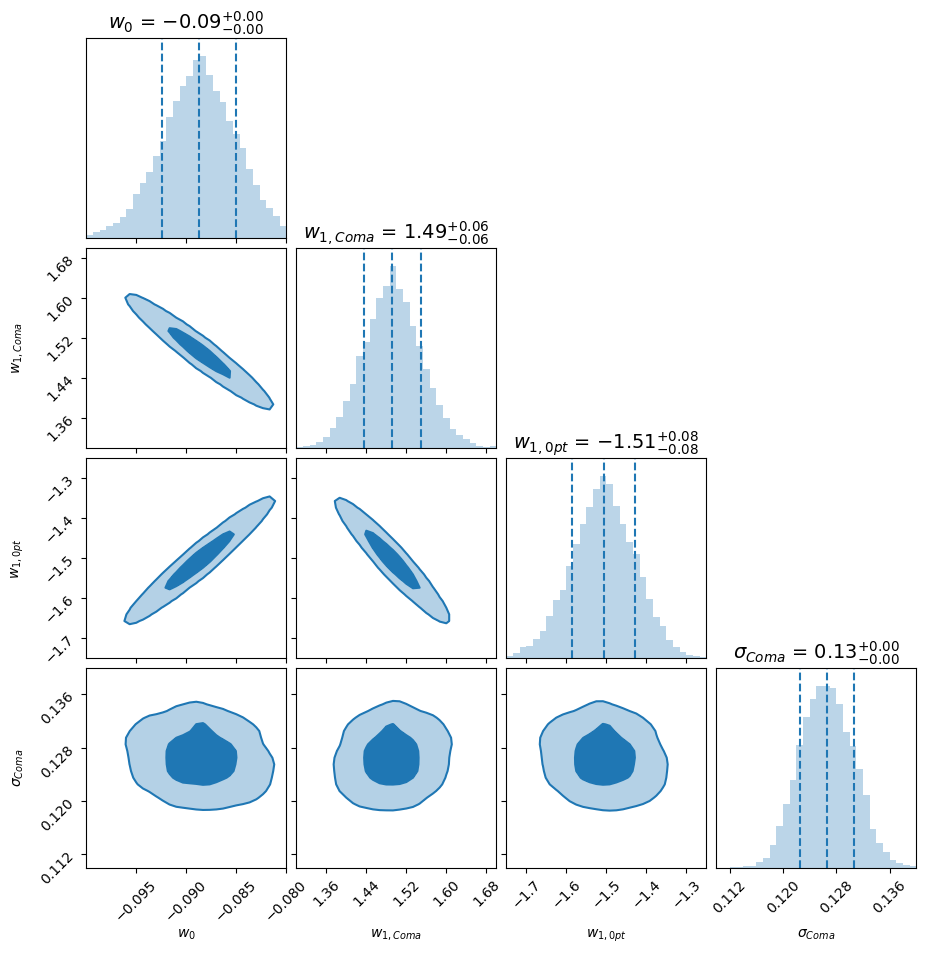

In [108]:
fig = corner.corner(itfr_mcmc_samples_bright3.T, bins=30, smooth=1,
                    range=[[-0.1, -0.08], [1.3, 1.7], [-1.75, -1.25], [0.11, 0.14]],   # Range for w0, w1, sigma. Adjust as needed.
                    labels=['$w_0$', '$w_{1, Coma}$', '$w_{1, 0 pt}$', r'$\sigma_{Coma}$'],
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)),
                    quantiles=[0.16, 0.5, 0.84],
                    color='tab:blue',
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    plot_datapoints=False,
                    fill_contours=True,
                    show_titles=True,
                    title = {'Joint fit of Coma and 0-pt calibrators'},
                    title_kwargs={"fontsize": 14});

In [109]:
a_itfr_bright3, b_itfr_bright3, cov_itfr_bright3 = param_invert(w0_bright3, w1_bright3, cov_w_bright3[:3,:3])

print(f'              w0: {w0_bright3:.3f} +/- {np.sqrt(cov_w_bright3[0,0]):.3f}')
print(f'         w1 Coma:  {w1_bright3[0]:.2f}  +/- {np.sqrt(cov_w_bright3[1,1]):.2f}')
print(f'          w1 0pt: {w1_bright3[1]:.2f}  +/- {np.sqrt(cov_w_bright3[2,2]):.2f}')
print(f'           slope: {a_itfr_bright3:.2f}  +/- {np.sqrt(cov_itfr_bright3[0,0]):.2f}')
print(f'y-intercept Coma:  {b_itfr_bright3[0]:.2f} +/- {np.sqrt(cov_itfr_bright3[1,1]):.2f}')
print(f' y-intercept 0pt: {b_itfr_bright3[1]:.2f} +/- {np.sqrt(cov_itfr_bright3[2,2]):.2f}')

              w0: -0.089 +/- 0.004
         w1 Coma:  1.49  +/- 0.06
          w1 0pt: -1.51  +/- 0.08
           slope: -11.28  +/- 0.48
y-intercept Coma:  16.82 +/- 0.08
 y-intercept 0pt: -16.99 +/- 0.20


In [110]:
# Invert the MCMC samples so that they represent (a, b) and not (w0, w1)
tfr_mcmc_samples_bright3 = np.zeros(itfr_mcmc_samples_bright3.shape)

tfr_mcmc_samples_bright3[0] = 1./itfr_mcmc_samples_bright3[0]
tfr_mcmc_samples_bright3[1] = -itfr_mcmc_samples_bright3[1]/itfr_mcmc_samples_bright3[0]
tfr_mcmc_samples_bright3[2] = -itfr_mcmc_samples_bright3[2]/itfr_mcmc_samples_bright3[0]
tfr_mcmc_samples_bright3[3] = itfr_mcmc_samples_bright3[3]

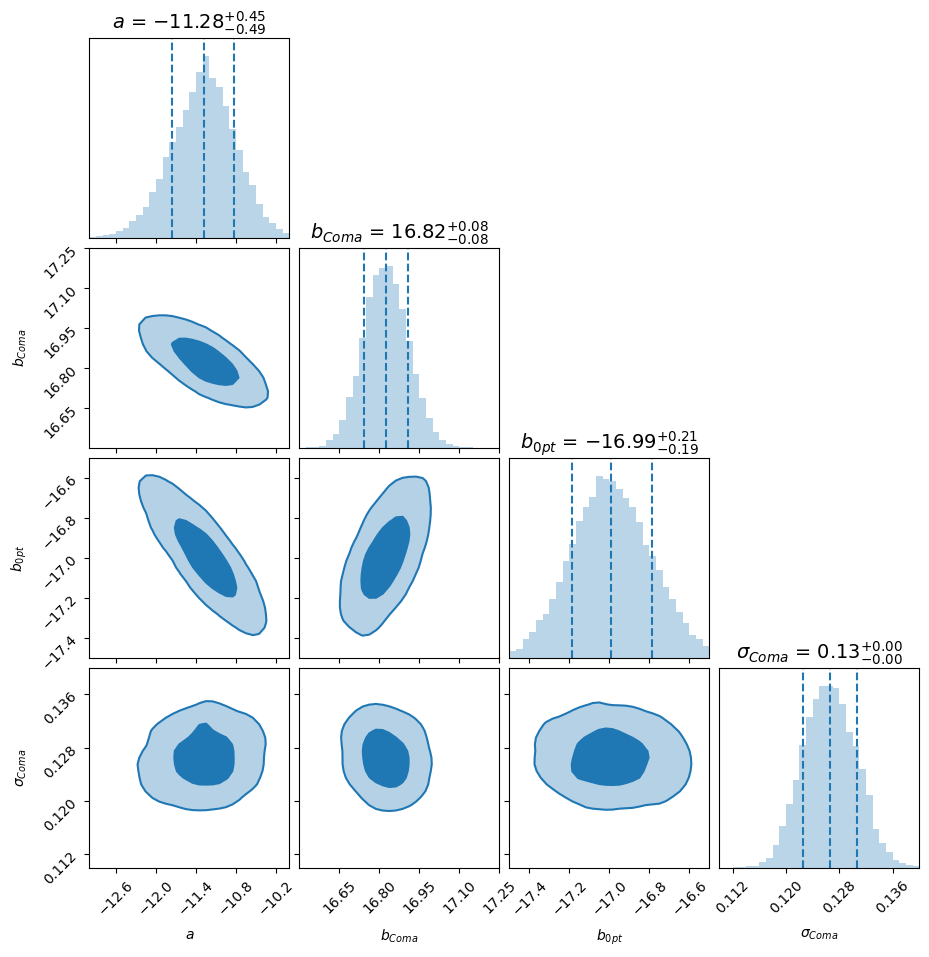

In [112]:
fig = corner.corner(tfr_mcmc_samples_bright3.T, bins=30, smooth=1,
                    range=[[-13.0, -10.0], [16.5, 17.25], [-17.5, -16.5], [0.11, 0.14]],
                    labels=['$a$', '$b_{Coma}$', '$b_{0pt}$', r'$\sigma_{Coma}$'],
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)),
                    quantiles=[0.16, 0.5, 0.84],
                    color='tab:blue',
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    plot_datapoints=False,
                    fill_contours=True,
                    show_titles=True,
                    title = {'Joint fit of Coma and 0-pt calibrators'},
                    title_kwargs={"fontsize": 14})

# fig.savefig('../../Figures/SV/fuji_Coma_corner_20240130.png', dpi=150)

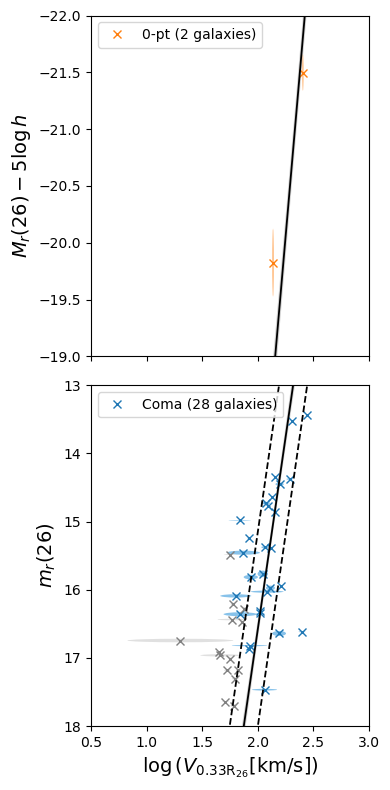

In [124]:
yvals_bright3 = np.zeros((len(b_itfr_bright3), len(xvals)))
for i in range(len(b_itfr_bright3)):
    yvals_bright3[i] = a_itfr_bright3 * (xvals - V0) + b_itfr_bright3[i]

################################################################################
# Get the MCMC 1-sigma quantiles to plot with the fit.
#-------------------------------------------------------------------------------
y_chain1_bright3 = np.outer(xvals - V0, tfr_mcmc_samples_bright3[0]) + tfr_mcmc_samples_bright3[1]
y_chain1_bright3_quantiles = np.quantile(y_chain1_bright3, [0.1587, 0.8414], axis=1)

y_chain2_bright3 = np.outer(xvals - V0, tfr_mcmc_samples_bright3[0]) + tfr_mcmc_samples_bright3[2]
y_chain2_bright3_quantiles = np.quantile(y_chain2_bright3, [0.1587, 0.8414], axis=1)
################################################################################


################################################################################
# Pack info into data
#-------------------------------------------------------------------------------
data1_bright3 = [np.log10(SGA_TF_bright3['V_0p33R26']), SGA_TF_bright3['R_MAG_SB26']]
x1_bright3_err = 0.434*SGA_TF_bright3['V_0p33R26_err']/SGA_TF_bright3['V_0p33R26']
y1_bright3_err = SGA_TF_bright3['R_MAG_SB26_ERR']
corr1_xy_bright3 = np.zeros_like(x1_bright3_err)

# Removed galaxies
data1_removed3 = [np.log10(SGA_TF['V_0p33R26'][dwarfs3]), SGA_TF['R_MAG_SB26'][dwarfs3]]
x1_err_removed3 = 0.434*SGA_TF['V_0p33R26_err'][dwarfs3]/SGA_TF['V_0p33R26'][dwarfs3]
y1_err_removed3 = SGA_TF['R_MAG_SB26_ERR'][dwarfs3]
corr1_xy_removed3 = np.zeros_like(x1_err_removed3)

# data2 is the same as the first fit
################################################################################


################################################################################
# Generate ellipses
#-------------------------------------------------------------------------------
ells1_bright3 = [
                Ellipse(
                    xy=[data1_bright3[0][i], data1_bright3[1][i]],
                    width=2*y1_bright3_err[i],
                    height=2*x1_bright3_err[i],
                    angle=np.rad2deg(np.arccos(corr1_xy_bright3[i])),
                )
                for i in range(len(data1_bright3[0]))
]

ells1_removed3 = [
                 Ellipse(
                     xy=[data1_removed3[0][i], data1_removed3[1][i]], 
                     width=2*y1_err_removed3[i], 
                     height=2*x1_err_removed3[i], 
                     angle=np.rad2deg(np.arccos(corr1_xy_removed3[i])), 
                 )
    for i in range(len(data1_removed3[0]))
]

# ells2 is the same as the first fit, but matplotlib won't let us reuse it
ells2_bright3 = [
                Ellipse(
                    xy=[data2[0][i], data2[1][i]],
                    width=2*y2_err[i],
                    height=2*x2_err[i],
                    angle=np.rad2deg(np.arccos(corr2_xy[i])),
                )
                for i in range(len(data2[0]))
]
################################################################################


################################################################################
# Make the plot
#-------------------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(2, 
                               figsize=(4,8), 
                               tight_layout=True, 
                               sharex=True)

#-------------------------------------------------------------------------------
# Coma
#-------------------------------------------------------------------------------
ax2.fill_between(xvals, 
                 y_chain1_bright3_quantiles[0], 
                 y_chain1_bright3_quantiles[1], 
                 color="lightgray")

for i, e in enumerate(ells1_bright3):
    ax2.add_artist(e)
    e.set_facecolor(adjust_lightness('tab:blue', amount=1.75))
for i, e in enumerate(ells1_removed3):
    ax2.add_artist(e)
    e.set_facecolor(adjust_lightness('gray', amount=1.75))
    
ax2.plot(data1_bright3[0], data1_bright3[1], 'x', 
         label='Coma ({} galaxies)'.format(len(SGA_TF_bright3)))
ax2.plot(data1_removed3[0], data1_removed3[1], 'x', c='gray')

ax2.plot(xvals, yvals_bright3[0], c="k", marker="None", ls="-", lw=1.3)
ax2.plot(xvals - sig_w_bright3[0], yvals_bright3[0], 
         c="k", marker="None", ls="--", lw=1.3)
ax2.plot(xvals + sig_w_bright3[0], yvals_bright3[0], 
         c="k", marker="None", ls="--", lw=1.3)

ax2.set_xlabel(r"$\log{(V_\mathrm{0.33R_{26}} [\mathrm{km/s}])}$", fontsize=14)
ax2.set_ylabel(r"$m_r(26)$", fontsize=14)

ax2.legend(loc='upper left')

plt.xlim(0.5, 3)
ax2.set_ylim(18, 13)
#-------------------------------------------------------------------------------
# 0-pt calibrators
#-------------------------------------------------------------------------------
ax1.fill_between(xvals, 
                 y_chain2_bright3_quantiles[0], 
                 y_chain2_bright3_quantiles[1], 
                 color='lightgray')

for i, e in enumerate(ells2_bright3):
    ax1.add_artist(e)
    e.set_facecolor(adjust_lightness('tab:orange', amount=1.25))
    
ax1.plot(data2[0], 
         data2[1], 
         'x', 
         c='tab:orange',
         label='0-pt ({} galaxies)'.format(len(SGA_0pt)))

ax1.plot(xvals, yvals_bright3[1], c='k', marker='None', ls='-', lw=1.3)

ax1.set_ylabel(r'$M_r (26) - 5\log h$', fontsize=14)

ax1.legend(loc='upper left')

ax1.set_ylim(-19, -22);
#-------------------------------------------------------------------------------
################################################################################

# plt.savefig('../../Figures/SV/fuji_Coma_TFR_20240130.png', dpi=150)

# Does this calibration result in any dwarf galaxies?

## Calculate the absolute magnitudes for the galaxies based on the current TF calibration

In [114]:
SGA_TF['R_ABSMAG_SB26_bright3'] = a_itfr_bright3*(np.log10(SGA_TF['V_0p33R26']) - V0) + b_itfr_bright3[1]

In [115]:
m4_random = tfr_mcmc_samples_bright3[0]
b4_random = tfr_mcmc_samples_bright3[2]

N_samples = len(m4_random)

SGA_TF['R_ABSMAG_SB26_bright3_err'] = np.nan

for i in range(len(SGA_TF)):
    
    v_random = rng.normal(SGA_TF['V_0p33R26'][i], SGA_TF['V_0p33R26_err'][i], size=N_samples)
    
    Ms = m4_random*(np.log10(v_random) - V0) + b4_random
    
    SGA_TF['R_ABSMAG_SB26_bright3_err'][i] = np.nanstd(Ms)

/tmp/ipykernel_2153320/2930793791.py:12: RuntimeWarning: invalid value encountered in log10
  Ms = m4_random*(np.log10(v_random) - V0) + b4_random


In [116]:
dwarfs4 = (SGA_TF['R_ABSMAG_SB26_bright3'] - SGA_TF['R_ABSMAG_SB26_bright3_err']) > -17

SGA_TF_bright4 = SGA_TF[~dwarfs4]

print(np.sum(dwarfs4))

18


# 4th recalibration

Using the `dwarfs4` sample

In [117]:
results_bright4 = hyperfit_line_multi([SGA_TF_bright4['R_MAG_SB26'], SGA_0pt['R_ABSMAG_SB26']],
                                      [np.log10(SGA_TF_bright4['V_0p33R26']) - V0, np.log10(SGA_0pt['V_0p33R26']) - V0], 
                                      [SGA_TF_bright4['R_MAG_SB26_ERR'], SGA_0pt['R_ABSMAG_SB26_err']], 
                                      [0.434*SGA_TF_bright4['V_0p33R26_err']/SGA_TF_bright4['V_0p33R26'], 0.434*SGA_0pt['V_0p33R26_err']/SGA_0pt['V_0p33R26']], 
                                      bounds_itfr)

w0_bright4, w1_bright4, sig_w_bright4, cov_w_bright4, itfr_mcmc_samples_bright4, hf_itfr_bright4 = results_bright4

     fun: -903.841549335939
     jac: array([-1.12922862, -0.04732783, -0.01660965, -2.15300133])
 message: 'Optimization terminated successfully.'
    nfev: 6440
     nit: 106
 success: True
       x: array([-0.08548093,  1.47101455, -1.43973045,  0.11143866])


100%|██████████| 1000/1000 [00:01<00:00, 553.97it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [32.50425802 32.61232075 32.55673785 42.28628896] / 2114.314448071134


100%|██████████| 1000/1000 [00:01<00:00, 519.54it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [45.69887924 47.98707832 47.27728199 38.03693493] / 2399.3539158354374


100%|██████████| 1000/1000 [00:01<00:00, 570.86it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [41.80009716 43.16099362 42.37199226 50.79081441] / 2539.5407206526866


100%|██████████| 1000/1000 [00:01<00:00, 568.55it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [42.1877254  42.78645357 43.14785458 41.66258303] / 2157.3927291682994


100%|██████████| 1000/1000 [00:01<00:00, 573.07it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [39.92529136 40.40588245 41.0436228  53.62111957] / 2681.055978382082


100%|██████████| 1000/1000 [00:01<00:00, 573.24it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [45.06774313 44.81903406 46.74246967 54.93843713] / 2746.921856642714


100%|██████████| 1000/1000 [00:01<00:00, 570.98it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [47.11659418 46.92851691 48.85983074 50.6615536 ] / 2533.077680212001


100%|██████████| 1000/1000 [00:01<00:00, 573.10it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [43.18102333 43.10138054 44.60742958 52.06850125] / 2603.425062432395


100%|██████████| 1000/1000 [00:01<00:00, 555.33it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [43.63831879 43.31146166 44.99402015 46.83584827] / 2341.7924135272283


100%|██████████| 1000/1000 [00:01<00:00, 562.28it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [45.91713123 45.36316368 47.29841583 43.92145803] / 2364.9207915502666


100%|██████████| 1000/1000 [00:01<00:00, 563.81it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [43.68361057 43.29062983 44.98787505 45.55832569] / 2277.916284381946


100%|██████████| 1000/1000 [00:01<00:00, 569.00it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [44.62527179 44.23192471 46.06383194 41.90000026] / 2303.191597240814


100%|██████████| 1000/1000 [00:01<00:00, 570.25it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [45.86781463 45.42964982 47.06365037 41.32937283] / 2353.18251833003


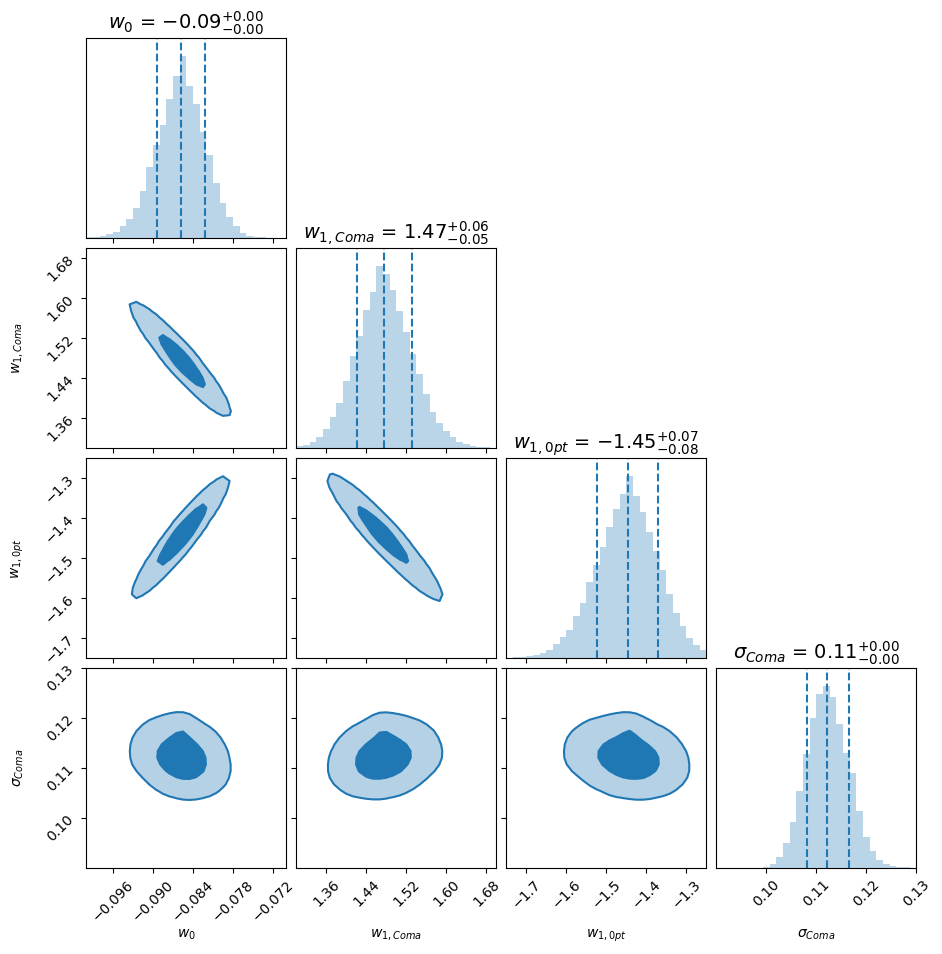

In [119]:
fig = corner.corner(itfr_mcmc_samples_bright4.T, bins=30, smooth=1,
                    range=[[-0.1, -0.07], [1.3, 1.7], [-1.75, -1.25], [0.09, 0.13]],   # Range for w0, w1, sigma. Adjust as needed.
                    labels=['$w_0$', '$w_{1, Coma}$', '$w_{1, 0 pt}$', r'$\sigma_{Coma}$'],
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)),
                    quantiles=[0.16, 0.5, 0.84],
                    color='tab:blue',
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    plot_datapoints=False,
                    fill_contours=True,
                    show_titles=True,
                    title = {'Joint fit of Coma and 0-pt calibrators'},
                    title_kwargs={"fontsize": 14});

In [120]:
a_itfr_bright4, b_itfr_bright4, cov_itfr_bright4 = param_invert(w0_bright4, w1_bright4, cov_w_bright4[:3,:3])

print(f'              w0: {w0_bright4:.3f} +/- {np.sqrt(cov_w_bright4[0,0]):.3f}')
print(f'         w1 Coma:  {w1_bright4[0]:.2f}  +/- {np.sqrt(cov_w_bright4[1,1]):.2f}')
print(f'          w1 0pt: {w1_bright4[1]:.2f}  +/- {np.sqrt(cov_w_bright4[2,2]):.2f}')
print(f'           slope: {a_itfr_bright4:.2f}  +/- {np.sqrt(cov_itfr_bright4[0,0]):.2f}')
print(f'y-intercept Coma:  {b_itfr_bright4[0]:.2f} +/- {np.sqrt(cov_itfr_bright4[1,1]):.2f}')
print(f' y-intercept 0pt: {b_itfr_bright4[1]:.2f} +/- {np.sqrt(cov_itfr_bright4[2,2]):.2f}')

              w0: -0.086 +/- 0.004
         w1 Coma:  1.47  +/- 0.06
          w1 0pt: -1.45  +/- 0.08
           slope: -11.66  +/- 0.50
y-intercept Coma:  17.20 +/- 0.10
 y-intercept 0pt: -16.86 +/- 0.21


In [121]:
# Invert the MCMC samples so that they represent (a, b) and not (w0, w1)
tfr_mcmc_samples_bright4 = np.zeros(itfr_mcmc_samples_bright4.shape)

tfr_mcmc_samples_bright4[0] = 1./itfr_mcmc_samples_bright4[0]
tfr_mcmc_samples_bright4[1] = -itfr_mcmc_samples_bright4[1]/itfr_mcmc_samples_bright4[0]
tfr_mcmc_samples_bright4[2] = -itfr_mcmc_samples_bright4[2]/itfr_mcmc_samples_bright4[0]
tfr_mcmc_samples_bright4[3] = itfr_mcmc_samples_bright4[3]

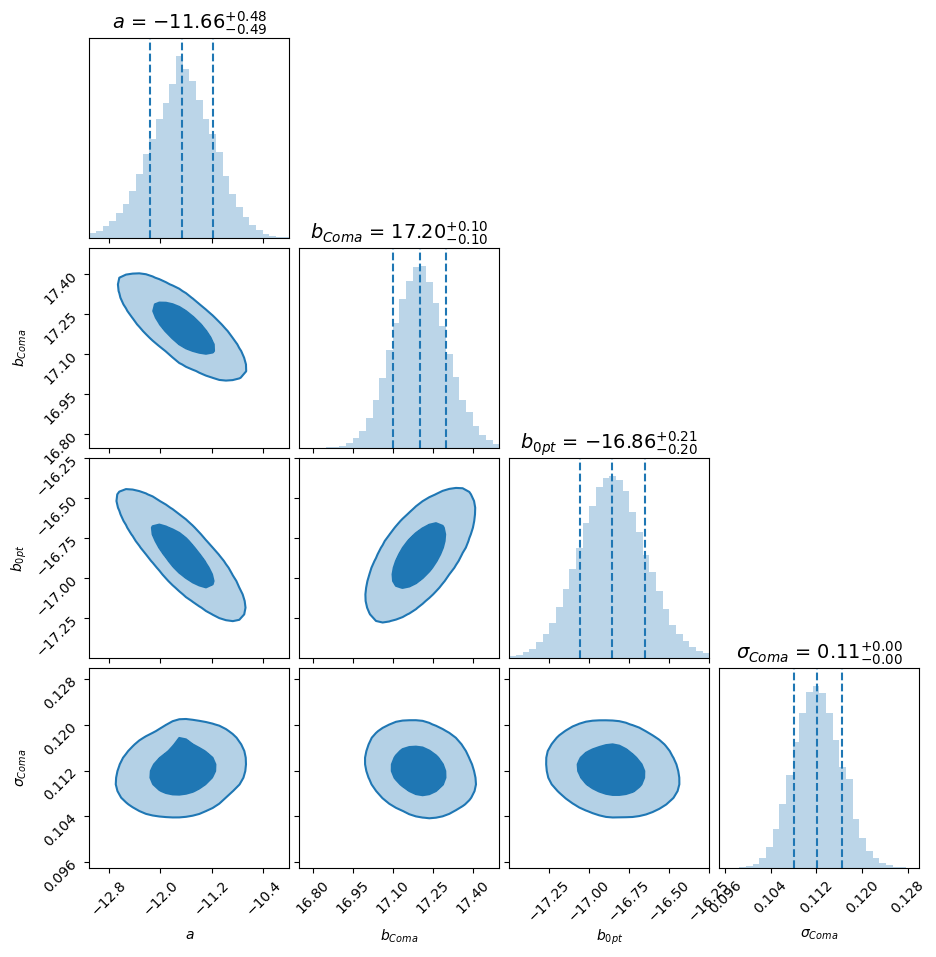

In [123]:
fig = corner.corner(tfr_mcmc_samples_bright4.T, bins=30, smooth=1,
                    range=[[-13.1, -10.0], [16.75, 17.5], [-17.5, -16.25], [0.095, 0.13]],
                    labels=['$a$', '$b_{Coma}$', '$b_{0pt}$', r'$\sigma_{Coma}$'],
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)),
                    quantiles=[0.16, 0.5, 0.84],
                    color='tab:blue',
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    plot_datapoints=False,
                    fill_contours=True,
                    show_titles=True,
                    title = {'Joint fit of Coma and 0-pt calibrators'},
                    title_kwargs={"fontsize": 14})

# fig.savefig('../../Figures/SV/fuji_Coma_corner_20240130.png', dpi=150)

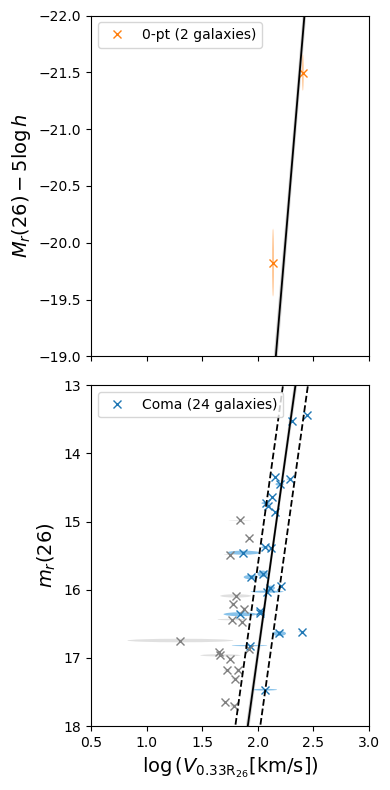

In [125]:
yvals_bright4 = np.zeros((len(b_itfr_bright4), len(xvals)))
for i in range(len(b_itfr_bright4)):
    yvals_bright4[i] = a_itfr_bright4 * (xvals - V0) + b_itfr_bright4[i]

################################################################################
# Get the MCMC 1-sigma quantiles to plot with the fit.
#-------------------------------------------------------------------------------
y_chain1_bright4 = np.outer(xvals - V0, tfr_mcmc_samples_bright4[0]) + tfr_mcmc_samples_bright4[1]
y_chain1_bright4_quantiles = np.quantile(y_chain1_bright4, [0.1587, 0.8414], axis=1)

y_chain2_bright4 = np.outer(xvals - V0, tfr_mcmc_samples_bright4[0]) + tfr_mcmc_samples_bright4[2]
y_chain2_bright4_quantiles = np.quantile(y_chain2_bright4, [0.1587, 0.8414], axis=1)
################################################################################


################################################################################
# Pack info into data
#-------------------------------------------------------------------------------
data1_bright4 = [np.log10(SGA_TF_bright4['V_0p33R26']), SGA_TF_bright4['R_MAG_SB26']]
x1_bright4_err = 0.434*SGA_TF_bright4['V_0p33R26_err']/SGA_TF_bright4['V_0p33R26']
y1_bright4_err = SGA_TF_bright4['R_MAG_SB26_ERR']
corr1_xy_bright4 = np.zeros_like(x1_bright4_err)

# Removed galaxies
data1_removed4 = [np.log10(SGA_TF['V_0p33R26'][dwarfs4]), SGA_TF['R_MAG_SB26'][dwarfs4]]
x1_err_removed4 = 0.434*SGA_TF['V_0p33R26_err'][dwarfs4]/SGA_TF['V_0p33R26'][dwarfs4]
y1_err_removed4 = SGA_TF['R_MAG_SB26_ERR'][dwarfs4]
corr1_xy_removed4 = np.zeros_like(x1_err_removed4)

# data2 is the same as the first fit
################################################################################


################################################################################
# Generate ellipses
#-------------------------------------------------------------------------------
ells1_bright4 = [
                Ellipse(
                    xy=[data1_bright4[0][i], data1_bright4[1][i]],
                    width=2*y1_bright4_err[i],
                    height=2*x1_bright4_err[i],
                    angle=np.rad2deg(np.arccos(corr1_xy_bright4[i])),
                )
                for i in range(len(data1_bright4[0]))
]

ells1_removed4 = [
                 Ellipse(
                     xy=[data1_removed4[0][i], data1_removed4[1][i]], 
                     width=2*y1_err_removed4[i], 
                     height=2*x1_err_removed4[i], 
                     angle=np.rad2deg(np.arccos(corr1_xy_removed4[i])), 
                 )
    for i in range(len(data1_removed4[0]))
]

# ells2 is the same as the first fit, but matplotlib won't let us reuse it
ells2_bright4 = [
                Ellipse(
                    xy=[data2[0][i], data2[1][i]],
                    width=2*y2_err[i],
                    height=2*x2_err[i],
                    angle=np.rad2deg(np.arccos(corr2_xy[i])),
                )
                for i in range(len(data2[0]))
]
################################################################################


################################################################################
# Make the plot
#-------------------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(2, 
                               figsize=(4,8), 
                               tight_layout=True, 
                               sharex=True)

#-------------------------------------------------------------------------------
# Coma
#-------------------------------------------------------------------------------
ax2.fill_between(xvals, 
                 y_chain1_bright4_quantiles[0], 
                 y_chain1_bright4_quantiles[1], 
                 color="lightgray")

for i, e in enumerate(ells1_bright4):
    ax2.add_artist(e)
    e.set_facecolor(adjust_lightness('tab:blue', amount=1.75))
for i, e in enumerate(ells1_removed4):
    ax2.add_artist(e)
    e.set_facecolor(adjust_lightness('gray', amount=1.75))
    
ax2.plot(data1_bright4[0], data1_bright4[1], 'x', 
         label='Coma ({} galaxies)'.format(len(SGA_TF_bright4)))
ax2.plot(data1_removed4[0], data1_removed4[1], 'x', c='gray')

ax2.plot(xvals, yvals_bright4[0], c="k", marker="None", ls="-", lw=1.3)
ax2.plot(xvals - sig_w_bright4[0], yvals_bright4[0], 
         c="k", marker="None", ls="--", lw=1.3)
ax2.plot(xvals + sig_w_bright4[0], yvals_bright4[0], 
         c="k", marker="None", ls="--", lw=1.3)

ax2.set_xlabel(r"$\log{(V_\mathrm{0.33R_{26}} [\mathrm{km/s}])}$", fontsize=14)
ax2.set_ylabel(r"$m_r(26)$", fontsize=14)

ax2.legend(loc='upper left')

plt.xlim(0.5, 3)
ax2.set_ylim(18, 13)
#-------------------------------------------------------------------------------
# 0-pt calibrators
#-------------------------------------------------------------------------------
ax1.fill_between(xvals, 
                 y_chain2_bright4_quantiles[0], 
                 y_chain2_bright4_quantiles[1], 
                 color='lightgray')

for i, e in enumerate(ells2_bright4):
    ax1.add_artist(e)
    e.set_facecolor(adjust_lightness('tab:orange', amount=1.25))
    
ax1.plot(data2[0], 
         data2[1], 
         'x', 
         c='tab:orange',
         label='0-pt ({} galaxies)'.format(len(SGA_0pt)))

ax1.plot(xvals, yvals_bright4[1], c='k', marker='None', ls='-', lw=1.3)

ax1.set_ylabel(r'$M_r (26) - 5\log h$', fontsize=14)

ax1.legend(loc='upper left')

ax1.set_ylim(-19, -22);
#-------------------------------------------------------------------------------
################################################################################

# plt.savefig('../../Figures/SV/fuji_Coma_TFR_20240130.png', dpi=150)

# Does this calibration result in any dwarf galaxies?

In [126]:
SGA_TF['R_ABSMAG_SB26_bright4'] = a_itfr_bright4*(np.log10(SGA_TF['V_0p33R26']) - V0) + b_itfr_bright4[1]

In [127]:
m5_random = tfr_mcmc_samples_bright4[0]
b5_random = tfr_mcmc_samples_bright4[2]

N_samples = len(m5_random)

SGA_TF['R_ABSMAG_SB26_bright4_err'] = np.nan

for i in range(len(SGA_TF)):
    
    v_random = rng.normal(SGA_TF['V_0p33R26'][i], SGA_TF['V_0p33R26_err'][i], size=N_samples)
    
    Ms = m5_random*(np.log10(v_random) - V0) + b5_random
    
    SGA_TF['R_ABSMAG_SB26_bright4_err'][i] = np.nanstd(Ms)

/tmp/ipykernel_2153320/2787392005.py:12: RuntimeWarning: invalid value encountered in log10
  Ms = m5_random*(np.log10(v_random) - V0) + b5_random


In [128]:
dwarfs5 = (SGA_TF['R_ABSMAG_SB26_bright4'] - SGA_TF['R_ABSMAG_SB26_bright4_err']) > -17

SGA_TF_bright5 = SGA_TF[~dwarfs5]

print(np.sum(dwarfs5))

18
